# Analysis of Australian Political Ads on Facebook
Author: Joshua Wang

In [37]:
from pyspark.sql.functions import concat, col, lower, lit, when, split, monotonically_increasing_id, to_timestamp, year, month, dayofmonth, sum, expr, avg

## Dataset Exploration and Cleaning

### Load datasets being used

In [2]:
# Load political ad dataset
df = spark.read.option("header", True).json('/data/ProjectDatasetFacebookAU/')

In [7]:
# Load all candidates and successfully elected candidates for 2022 federal election (for both house of representatives and senate)
house_candidates = spark.read.option("header", True).csv('/user/s4696561/project/house-candidates.csv')
house_elected = spark.read.option("header", True).csv('/user/s4696561/project/representatives.csv')
senate_candidates = spark.read.option("header", True).csv('/user/s4696561/project/senate-candidates.csv')
senate_elected = spark.read.option("header", True).csv('/user/s4696561/project/senators.csv')

### Schemas of datasets

In [8]:
df.printSchema()

root
 |-- ad_creation_time: string (nullable = true)
 |-- ad_creative_bodies: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_body: string (nullable = true)
 |-- ad_creative_link_caption: string (nullable = true)
 |-- ad_creative_link_captions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_link_description: string (nullable = true)
 |-- ad_creative_link_descriptions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_link_title: string (nullable = true)
 |-- ad_creative_link_titles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_delivery_start_time: string (nullable = true)
 |-- ad_delivery_stop_time: string (nullable = true)
 |-- ad_snapshot_url: string (nullable = true)
 |-- bylines: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- delivery_by_region: array (nullable = true)
 |    |-- element: struct (containsN

In [9]:
df.head()

24/04/27 12:06:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Row(ad_creation_time='2021-11-21', ad_creative_bodies=None, ad_creative_body="I'm ready to fight Scott Morrison's Cashless Pension Card being rolled out in Lilley.", ad_creative_link_caption=None, ad_creative_link_captions=None, ad_creative_link_description=None, ad_creative_link_descriptions=None, ad_creative_link_title='Cashless Pension Card', ad_creative_link_titles=None, ad_delivery_start_time='2021-11-21', ad_delivery_stop_time=None, ad_snapshot_url='https://www.facebook.com/ads/archive/render_ad/?id=966461410889234&access_token=EAAG7mM7GdIsBADfD3puwsjZBZCoYLv4bKLXwzw6Fdne1DYSDXo0je6isRr8yEgaZAxFncyzRs1RPJxebw77MaXZBI12hOs9cjPVAN11L4vrY6ddT1dEZCoEOFje4uBkA1Nn6kY3FkgO7zZBNpxUpkq2ijrzRaa2Mm1EyZCGdz3KcS6KDaHduw6NfcorBcQwKq0ZD', bylines=None, currency='AUD', delivery_by_region=None, demographic_distribution=[Row(age='55-64', gender='unknown', percentage='0.001232'), Row(age='65+', gender='unknown', percentage='0.017252'), Row(age='55-64', gender='female', percentage='0.057917'), Row(a

In [10]:
house_candidates.printSchema()
house_elected.printSchema()
senate_candidates.printSchema()
senate_elected.printSchema()

root
 |-- state: string (nullable = true)
 |-- division: string (nullable = true)
 |-- ballotPosition: string (nullable = true)
 |-- surname: string (nullable = true)
 |-- ballotGivenName: string (nullable = true)
 |-- partyBallotName: string (nullable = true)

root
 |-- Person ID: string (nullable = true)
 |-- First name: string (nullable = true)
 |-- Last name: string (nullable = true)
 |-- Party: string (nullable = true)
 |-- Division: string (nullable = true)
 |-- URI: string (nullable = true)

root
 |-- state: string (nullable = true)
 |-- column: string (nullable = true)
 |-- ballotPosition: string (nullable = true)
 |-- surname: string (nullable = true)
 |-- ballotGivenName: string (nullable = true)
 |-- groupName: string (nullable = true)
 |-- partyBallotName: string (nullable = true)

root
 |-- Person ID: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Party: string (nullable = true)
 |-- URI: string (nullable = true)



### Cleaning Data

In [11]:
ad_data = df.select(
    "id",
    "page_id",
    "demographic_distribution", # breakdown of age and gender groups presented with the ad
    "funding_entity", # person paying for ad
    "page_name", # page paying for ad (likely the same as funding_entity, included for checking)
    "impressions", # number of people who saw the ad - gives a lower and upper bound
    "region_distribution", # which states/territories the ad is run in
    "spend", # cost of ad - gives a lower and upper bound
    "ad_creation_time"
).withColumnRenamed(
    "id", "ad_id"
)

In [12]:
# Need to fix names since candidates file includes middle names but elected people only records first names - this will mess up joins and ad searching so change to only using first names
house_candidates = house_candidates.withColumn("ballotGivenName", split(col("ballotGivenName"), " ")[0])
senate_candidates = senate_candidates.withColumn("ballotGivenName", split(col("ballotGivenName"), " ")[0])

In [13]:
# Give an ID to each candidate for easier tracking of people
house_candidates = house_candidates.withColumn("id", monotonically_increasing_id())
senate_candidates = senate_candidates.withColumn("id", monotonically_increasing_id() + house_candidates.count())

In [14]:
# In 2023, Cameron Caldwell was elected after the resignation of Stuart Robert.
# Since my analysis is focussed on ad spending leading up to the 2022 federal elections, Stuart Robert will be considered as "elected" rather than Cameron.
# Manually replace Cameron Caldwell with Stuart Robert in successful candidates dataframe.
house_elected = house_elected.withColumn(
    "First name",
    when(house_elected["First name"] == "Cameron", "Stuart")
    .otherwise(house_elected["First name"])
).withColumn(
    "Last name",
    when(house_elected["Last name"] == "Caldwell", "Robert")
    .otherwise(house_elected["Last name"])
)

In [15]:
# Get full names for all entries in each dataset and convert all to lowercase for easier comparison with ad data
house_candidate_concatenated = house_candidates.withColumn("full_name", concat(lower(col("ballotGivenName")), lit(" "), lower(col("surname"))))
senate_candidate_concatenated = senate_candidates.withColumn("full_name", concat(lower(col("ballotGivenName")), lit(" "), lower(col("surname"))))
house_elected_concatenated = house_elected.withColumn("full_name", concat(lower(col("First name")), lit(" "), lower(col("Last name"))))
senate_elected_concatenated = senate_elected.withColumn("full_name", lower(col("Name"))) 

In [16]:
# Only take data we need for more efficient processing and rename data for consistency
house_candidates_details = house_candidate_concatenated.select("id", "full_name", "partyBallotName", "state").withColumnRenamed("partyBallotName", "party")
senate_candidates_details = senate_candidate_concatenated.select("id", "full_name", "partyBallotName", "state").withColumnRenamed("partyBallotName", "party")

In [17]:
# Some parties used different names on ballots - standardise these
house_candidates_details = house_candidates_details.withColumn(
    "party",
    when(
        (house_candidates_details["party"] == "A.L.P.") | (house_candidates_details["party"] == "Labor"),
        "Australian Labor Party"
    ).when(
        (house_candidates_details["party"] == "The Greens (WA)") | (house_candidates_details["party"] == "Queensland Greens")
        | (house_candidates_details["party"] == "The Greens"),
        "Australian Greens"
    ).when(
        (house_candidates_details["party"] == "Liberal National Party of Queensland") | (house_candidates_details["party"] == "Liberal")
        | (house_candidates_details["party"] == "Liberal Party") | (house_candidates_details["party"] == "National Party")
        | (house_candidates_details["party"] == "The Nationals"),
        "Liberal-National Coalition" # Consider liberal and national parties as one party since they often run together
    ).when(
        (house_candidates_details["party"] == "Democratic Alliance"),
        "Drew Pavlou Democratic Alliance"
    ).when(
        (house_candidates_details["party"].isNull()),
        "Independent"
    )
    .otherwise(house_candidates_details["party"])
)

senate_candidates_details = senate_candidates_details.withColumn(
    "party",
    when(
        (senate_candidates_details["party"] == "A.L.P.") | (senate_candidates_details["party"] == "Labor"),
        "Australian Labor Party"
    ).when(
        (senate_candidates_details["party"] == "The Greens (WA)") | (senate_candidates_details["party"] == "Queensland Greens")
        | (senate_candidates_details["party"] == "The Greens"),
        "Australian Greens"
    ).when(
        (senate_candidates_details["party"] == "Liberal National Party of Queensland") | (senate_candidates_details["party"] == "Liberal")
        | (senate_candidates_details["party"] == "Liberal Party") | (senate_candidates_details["party"] == "National Party")
        | (senate_candidates_details["party"] == "The Nationals"),
        "Liberal-National Coalition" # Consider liberal and national parties as one party since they often run together
    ).when(
        (senate_candidates_details["party"] == "Democratic Alliance"),
        "Drew Pavlou Democratic Alliance"
    ).when(
        (senate_candidates_details["party"].isNull()),
        "Independent"
    )
    .otherwise(senate_candidates_details["party"])
)

In [18]:
# Dataset of elected candidates doesn't contain state represented - get this from all candidates dataset
house_elected_details = house_elected_concatenated.join(
    house_candidates_details,
    house_candidates_details.full_name == house_elected_concatenated.full_name,
    'left'
).select(
    "id",
    house_elected_concatenated.full_name,
    house_candidates_details.party,
    "state"
)

# There are 2 "David Smiths" and no way to filter based off information available, so drop the incorrect one manually
house_elected_details = house_elected_details.filter(
    ~((house_elected_details["full_name"] == "david smith")
      & (house_elected_details["party"] == "United Australia Party"))
)

In [19]:
# Only 40 of the total 76 seats in the senate were availabe during the 2022 federal election (was a half senate election, other half continuing from 2019).
# We will only analyse ad spending of senate candidates running in the 2022 election, as ad data for 2019 is unavailable.
# Resignations and other factors result in only 36 senators available for analysis.
senate_elected_details = senate_elected_concatenated.join(
    senate_candidates_details,
    senate_candidates_details.full_name == senate_elected_concatenated.full_name,
    'inner'
).select(
    "id",
    senate_elected_concatenated.full_name,
    senate_candidates_details.party,
    "state"
)

### Resulting Schemas and Sizes of Datasets

In [20]:
ad_data.printSchema()

root
 |-- ad_id: string (nullable = true)
 |-- page_id: string (nullable = true)
 |-- demographic_distribution: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- age: string (nullable = true)
 |    |    |-- gender: string (nullable = true)
 |    |    |-- percentage: string (nullable = true)
 |-- funding_entity: string (nullable = true)
 |-- page_name: string (nullable = true)
 |-- impressions: struct (nullable = true)
 |    |-- lower_bound: string (nullable = true)
 |    |-- upper_bound: string (nullable = true)
 |-- region_distribution: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- percentage: string (nullable = true)
 |    |    |-- region: string (nullable = true)
 |-- spend: struct (nullable = true)
 |    |-- lower_bound: string (nullable = true)
 |    |-- upper_bound: string (nullable = true)
 |-- ad_creation_time: string (nullable = true)



In [21]:
house_candidates_details.printSchema()
senate_candidates_details.printSchema()
house_elected_details.printSchema()
senate_elected_details.printSchema()

root
 |-- id: long (nullable = false)
 |-- full_name: string (nullable = true)
 |-- party: string (nullable = true)
 |-- state: string (nullable = true)

root
 |-- id: long (nullable = false)
 |-- full_name: string (nullable = true)
 |-- party: string (nullable = true)
 |-- state: string (nullable = true)

root
 |-- id: long (nullable = true)
 |-- full_name: string (nullable = true)
 |-- party: string (nullable = true)
 |-- state: string (nullable = true)

root
 |-- id: long (nullable = false)
 |-- full_name: string (nullable = true)
 |-- party: string (nullable = true)
 |-- state: string (nullable = true)



## Joining Datasets for Analysis

In [22]:
# Create a single dataset of all candidates and two additional columns:
#    - election_type: [house, senate]
#    - elected: [True, False]
house_data = house_candidates_details.alias('a').join(
    house_elected_details.alias('b'),
    col("a.id") == col("b.id"), "left"
).withColumn(
    "elected", col("b.id").isNotNull()
).withColumn(
    "election_type", lit("house")
).select(
    "a.id",
    "a.full_name",
    "a.party",
    "a.state",
    "elected",
    "election_type"
)

senate_data = senate_candidates_details.alias('a').join(
    senate_elected_details.alias('b'),
    col("a.id") == col("b.id"), "left"
).withColumn(
    "elected", col("b.id").isNotNull()
).withColumn(
    "election_type", lit("senate")
).select(
    "a.id",
    "a.full_name",
    "a.party",
    "a.state",
    "elected",
    "election_type"
)

In [23]:
# Dataframe with all candidates
all_candidates = house_data.union(senate_data)

In [24]:
all_candidates.printSchema()

root
 |-- id: long (nullable = false)
 |-- full_name: string (nullable = true)
 |-- party: string (nullable = true)
 |-- state: string (nullable = true)
 |-- elected: boolean (nullable = false)
 |-- election_type: string (nullable = false)



In [25]:
# Take subset of ad where they are run by candidates in the election
ad_data = ad_data.withColumn("funding_entity", lower(ad_data["funding_entity"]))
candidate_ads = ad_data.join(
    all_candidates,
    ad_data["funding_entity"].contains(all_candidates["full_name"]),
    "inner"
)

In [26]:
candidate_ads.persist()

DataFrame[ad_id: string, page_id: string, demographic_distribution: array<struct<age:string,gender:string,percentage:string>>, funding_entity: string, page_name: string, impressions: struct<lower_bound:string,upper_bound:string>, region_distribution: array<struct<percentage:string,region:string>>, spend: struct<lower_bound:string,upper_bound:string>, ad_creation_time: string, id: bigint, full_name: string, party: string, state: string, elected: boolean, election_type: string]

In [27]:
# candidate_ads.write.json("/user/s4696561/project/candidate_ads/", "overwrite")

## Data Analysis

In [3]:
### Load in candidate_ads from json back-up if kernel dies :(
candidate_ads = spark.read.option("header", True).json('/user/s4696561/project/candidate_ads/')

24/05/14 23:55:43 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


In [228]:
candidate_ads.show()

+----------------+----------------+------------------------+-------+-------------+--------------------+--------------------+----+--------------+---------------+--------------------+--------------------+--------------------+------------+-----+
|ad_creation_time|           ad_id|demographic_distribution|elected|election_type|           full_name|      funding_entity|  id|   impressions|        page_id|           page_name|               party| region_distribution|       spend|state|
+----------------+----------------+------------------------+-------+-------------+--------------------+--------------------+----+--------------+---------------+--------------------+--------------------+--------------------+------------+-----+
|      2020-09-17| 752439155316068|    [{65+, unknown, 0...|   true|       senate|     deborah o'neill|     deborah o'neill|1284|      {0, 999}|120961761279906|     Deborah O'Neill|Australian Labor ...|[{1, New South Wa...|     {0, 99}|  NSW|
|      2020-09-15|2598280693

### Ad Spending over Time

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

In [7]:
# Convert ad_creation_time to timestamp
candidate_ads = candidate_ads.withColumn("ad_creation_time", to_timestamp(col("ad_creation_time")))

In [8]:
# Extract time components
candidate_ads = candidate_ads.withColumn("year", year("ad_creation_time"))
candidate_ads = candidate_ads.withColumn("month", month("ad_creation_time"))
candidate_ads = candidate_ads.withColumn("day", dayofmonth("ad_creation_time"))

In [9]:
# Aggregate spending over time
spending_over_time = candidate_ads.groupBy(
    "year", "month", "day"
).agg(
    sum("spend.lower_bound").alias("lower_bound_spend"),
    sum("spend.upper_bound").alias("upper_bound_spend"),
)

In [10]:
spending_over_time.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- lower_bound_spend: double (nullable = true)
 |-- upper_bound_spend: double (nullable = true)



In [11]:
spending_pd = spending_over_time.toPandas()
spending_pd['date'] = pd.to_datetime(spending_pd[['year', 'month', 'day']])
spending_pd = spending_pd.sort_values(by='date')

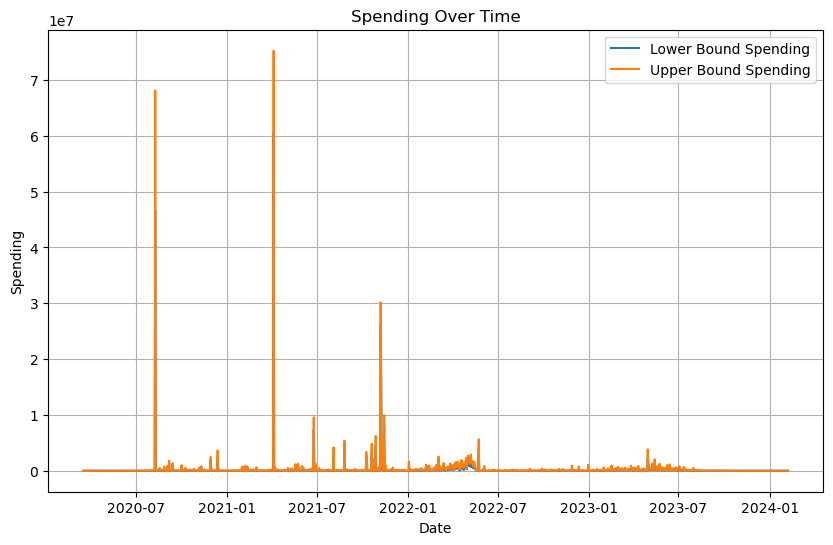

In [12]:
# Plotting the spending over time
plt.figure(figsize=(10, 6))
plt.plot(spending_pd['date'], spending_pd["lower_bound_spend"], label='Lower Bound Spending')
plt.plot(spending_pd['date'], spending_pd["upper_bound_spend"], label='Upper Bound Spending')
plt.xlabel('Date')
plt.ylabel('Spending')
plt.title('Spending Over Time')
plt.legend()
plt.grid(True)
plt.show()

We observe that there are anomalies in the data above, with some particular days having extremely high spending.

In [13]:
spending_pd = spending_pd.sort_values(by="lower_bound_spend", ascending=False)
spending_pd.head()

,year,month,day,lower_bound_spend,upper_bound_spend,date
923,2021,4,5,60631500.0,75247301.0,2021-04-05
550,2020,8,9,46755000.0,68120860.0,2020-08-09
1260,2021,11,7,26160200.0,30163427.0,2021-11-07
1303,2021,11,8,15208300.0,18107109.0,2021-11-08
748,2021,11,14,8193800.0,9933356.0,2021-11-14


In [14]:
id_list = candidate_ads.filter((col("ad_creation_time") == "2021-04-05")).select("ad_id").distinct().collect()
df.filter(col("id").isin([row.ad_id for row in id_list]) & (col("ad_creation_time") == "2021-04-05")).groupBy(
    "id", "ad_creative_body"
).agg(
    sum("spend.lower_bound").alias("lower_bound_spend"),
    sum("spend.upper_bound").alias("upper_bound_spend")
).select("id", "ad_creative_body", "lower_bound_spend", "upper_bound_spend").toPandas()

,id,ad_creative_body,lower_bound_spend,upper_bound_spend
0,198359791795746,Member of Parliament for the Federal Seat of F...,36651800.0,43058694.0
1,198359791795746,None,23940000.0,32103367.0
2,911957679633884,Scott Morrison's desperate Cabinet reshuffle i...,17900.0,36710.0
3,277821950475182,Do you know a local volunteer organisation tha...,0.0,297.0
4,200913344825237,Like this Page if you are tired of how the Lib...,0.0,2673.0
5,2856353881350698,LIKE to join the fight to stop NDIS Independen...,0.0,2673.0
6,126990412734895,"Husband to Skye, dad and stepdad, guitar, pian...",11500.0,14470.0
7,133136365373911,"Working to cement our local economic recovery,...",3000.0,5970.0
8,447511116354548,VOLUNTEER GRANTS ARE OPEN\n\nVolunteer Grants ...,0.0,1881.0
9,4320824361261588,Do you have a federal issue you'd like to chat...,0.0,495.0


In [13]:
id_list = candidate_ads.filter((col("ad_creation_time") == "2020-08-09")).select("ad_id").distinct().collect()
df.filter(col("id").isin([row.ad_id for row in id_list]) & (col("ad_creation_time") == "2020-08-09")).groupBy(
    "id", "ad_creative_body"
).agg(
    sum("spend.lower_bound").alias("lower_bound_spend"),
    sum("spend.upper_bound").alias("upper_bound_spend")
).select("id", "ad_creative_body", "lower_bound_spend", "upper_bound_spend").toPandas()

,id,ad_creative_body,lower_bound_spend,upper_bound_spend
0,2628325640740192,"Peter Khalil MP, Federal Member for Wills. Jo...",44775000.0,65479903.0
1,2628325640740192,None,1980000.0,2639868.0


In [14]:
id_list = candidate_ads.filter((col("ad_creation_time") == "2021-11-07")).select("ad_id").distinct().collect()
df.filter(col("id").isin([row.ad_id for row in id_list]) & (col("ad_creation_time") == "2021-11-07")).groupBy(
    "id", "ad_creative_body"
).agg(
    sum("spend.lower_bound").alias("lower_bound_spend"),
    sum("spend.upper_bound").alias("upper_bound_spend")
).select("id", "ad_creative_body", "lower_bound_spend", "upper_bound_spend").toPandas()

,id,ad_creative_body,lower_bound_spend,upper_bound_spend
0,2944693772446260,Demand an end to all coercive measures by gove...,15224500.0,17090192.0
1,481349949786281,Demand an end to all coercive measures by gove...,10150900.0,11842003.0
2,1535265330144811,Available now: the latest edition of my local ...,0.0,48609.0
3,302085041557273,Demand an end to all coercive measures by gove...,678300.0,1014603.0
4,343866357506965,Nominate someone who has gone above and beyond...,6700.0,9373.0
5,604451284334842,Nominate someone who has gone above and beyond...,7700.0,10373.0
6,313472176930772,The Morrison Government’s commitment to Medica...,1800.0,8235.0
7,557571405341669,The Morrison Government’s commitment to Medica...,42600.0,58635.0
8,954343818489786,"The Morrison Government has added over 2,700 m...",10000.0,12673.0
9,625326338821931,The Morrison Government is making childcare mo...,20100.0,27272.0


In [15]:
id_list = candidate_ads.filter((col("ad_creation_time") == "2021-11-08")).select("ad_id").distinct().collect()
df.filter(col("id").isin([row.ad_id for row in id_list]) & (col("ad_creation_time") == "2021-11-08")).groupBy(
    "id", "ad_creative_body"
).agg(
    sum("spend.lower_bound").alias("lower_bound_spend"),
    sum("spend.upper_bound").alias("upper_bound_spend")
).select("id", "ad_creative_body", "lower_bound_spend", "upper_bound_spend").toPandas()

,id,ad_creative_body,lower_bound_spend,upper_bound_spend
0,438240927736473,Attention Ryde Residents:\n \nStay safe this e...,46100.0,93620.0
1,428011822321779,"On the 21st of October 2021, I introduced my C...",13514900.0,16057404.0
2,2986693031571148,"On the 21st of October 2021, I introduced my C...",1622800.0,1899604.0
3,621397029273952,Applications are now open for businesses in No...,7800.0,10473.0
4,4630808530275236,Voting is your super power!\n \nIn the middle ...,3100.0,7852.0
5,589554388828525,Meet Ann from Frankston South. \n\nAnn is 74 a...,0.0,1386.0
6,964015844188061,Posting thank you cards to more of our local p...,0.0,1386.0
7,291372306047406,"Protecting our lifestyle, securing our future....",6600.0,8782.0
8,1066237010875587,"Click ""FOLLOW"" to keep informed about the work...",500.0,2282.0
9,3218008445086164,Delivering on my commitment to get you home so...,200.0,1982.0


In [16]:
id_list = candidate_ads.filter((col("ad_creation_time") == "2021-11-14")).select("ad_id").distinct().collect()
df.filter(col("id").isin([row.ad_id for row in id_list]) & (col("ad_creation_time") == "2021-11-14")).groupBy(
    "id", "ad_creative_body"
).agg(
    sum("spend.lower_bound").alias("lower_bound_spend"),
    sum("spend.upper_bound").alias("upper_bound_spend")
).select("id", "ad_creative_body", "lower_bound_spend", "upper_bound_spend").toPandas()

,id,ad_creative_body,lower_bound_spend,upper_bound_spend
0,4540374286050898,"On Dec 4th vote 1 Group D for business sense, ...",200.0,47423.0
1,1069250927197347,This week Mr Morrison wants everyone to forget...,8173500.0,9843637.0
2,4812325155474016,The state government have said that they won't...,3900.0,5187.0
3,670020411024827,Too many people in Forde experience unreliable...,0.0,792.0
4,308222827586362,I’m proud of my track record of securing Glads...,500.0,1688.0
5,3116780941978856,MOBILE BLACK SPOTS: The Morrison Government ar...,0.0,1485.0
6,592800128441773,Good morning Frankston!\n\nTerrific chats this...,0.0,990.0
7,403122977965773,Plenty Foods in Kingaroy are set for a massive...,900.0,2880.0
8,591534985326361,MOBILE BLACK SPOTS: The Morrison Government ar...,0.0,1485.0
9,568526430893802,"Only Labor has a plan for good, secure jobs in...",100.0,1288.0


By analysing the days with the greatest ad spending, we can find that ads with ad_id 198359791795746 and 2628325640740192 are anomalies as they spend a significant amount asking people to follow their page, and also have a repeated ad with nothing in the posting. I will remove these before further analysis.

In [15]:
# Remove anomalies
candidate_ads = candidate_ads.filter(~candidate_ads["ad_id"].isin([198359791795746, 2628325640740192]))

In [16]:
# Political events which occurred
events = {
    pd.to_datetime("2020-10-17"): "ACT Election",
    pd.to_datetime("2020-10-31"): "QLD Election",
    pd.to_datetime("2022-11-26"): "VIC Election",
    pd.to_datetime("2023-03-25"): "NSW Election",
    pd.to_datetime("2020-08-22"): "NT Election",
    pd.to_datetime("2021-03-13"): "WA Election",
    pd.to_datetime("2021-05-01"): "TAS Election",
    pd.to_datetime("2022-03-19"): "SA Election",
    pd.to_datetime("2022-05-21"): "Federal Election",
}

In [17]:
# Aggregate spending over time over new data
spending_over_time = candidate_ads.groupBy(
    "year", "month", "day"
).agg(
    sum("spend.lower_bound").alias("lower_bound_spend"),
    sum("spend.upper_bound").alias("upper_bound_spend"),
)

In [18]:
spending_pd = spending_over_time.toPandas()
spending_pd['date'] = pd.to_datetime(spending_pd[['year', 'month', 'day']])
spending_pd = spending_pd.sort_values(by='date')

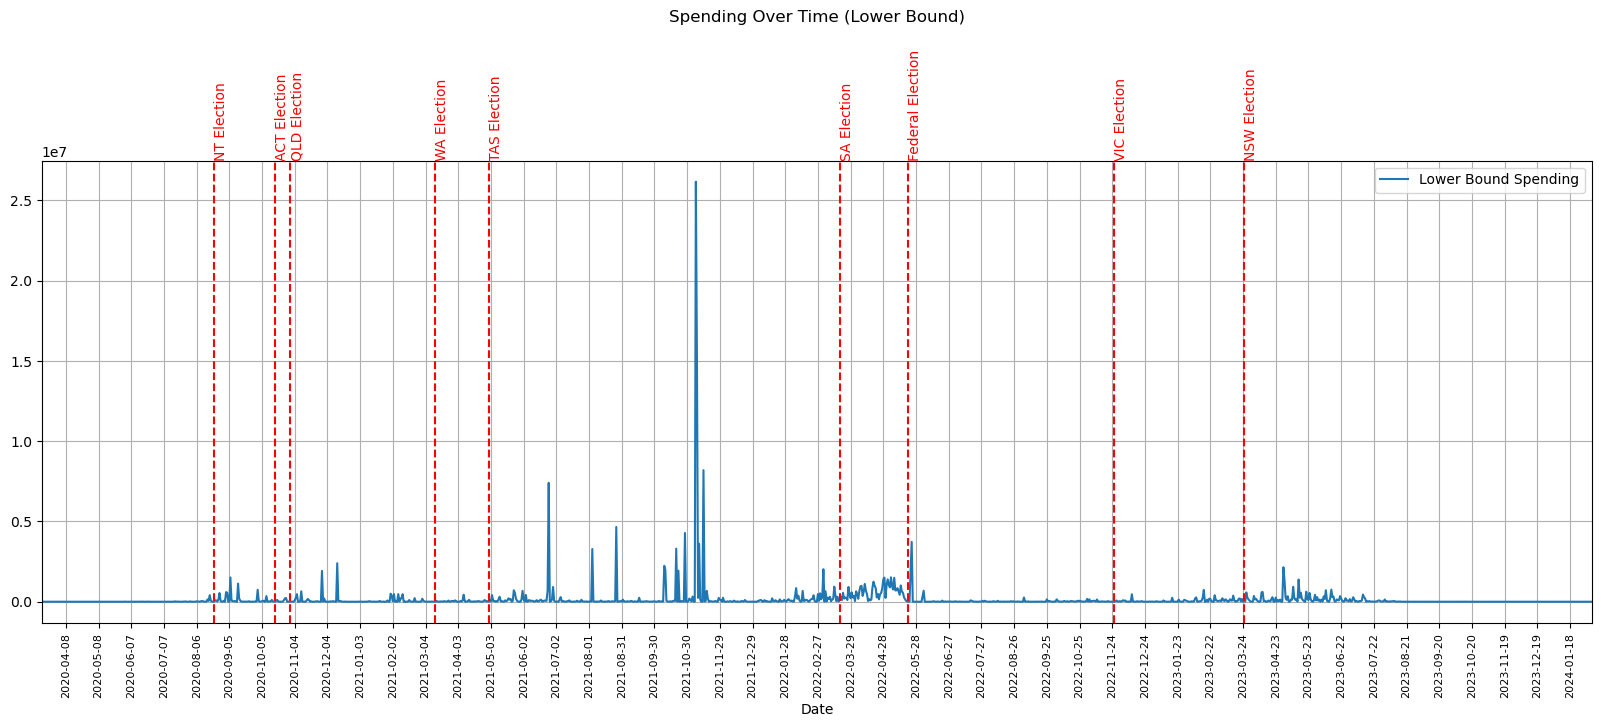

In [19]:
# Plotting the spending over time
plt.figure(figsize=(20, 6))
plt.plot(spending_pd['date'], spending_pd["lower_bound_spend"], label='Lower Bound Spending')
plt.xlabel('Date')
locator = MaxNLocator(integer=True, nbins=48)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().set_xlim(min(spending_pd["date"]), max(spending_pd["date"]))
plt.xticks(rotation=90, ha='center', fontsize=8)

# Show political events
for date, event in events.items():
    plt.axvline(x=date, color='red', linestyle='--')
    plt.text(date, plt.ylim()[1], event, color='red', fontsize=10, rotation=90, verticalalignment='bottom')

plt.title('Spending Over Time (Lower Bound)', pad=100)
plt.legend()
plt.grid(True)
plt.show()

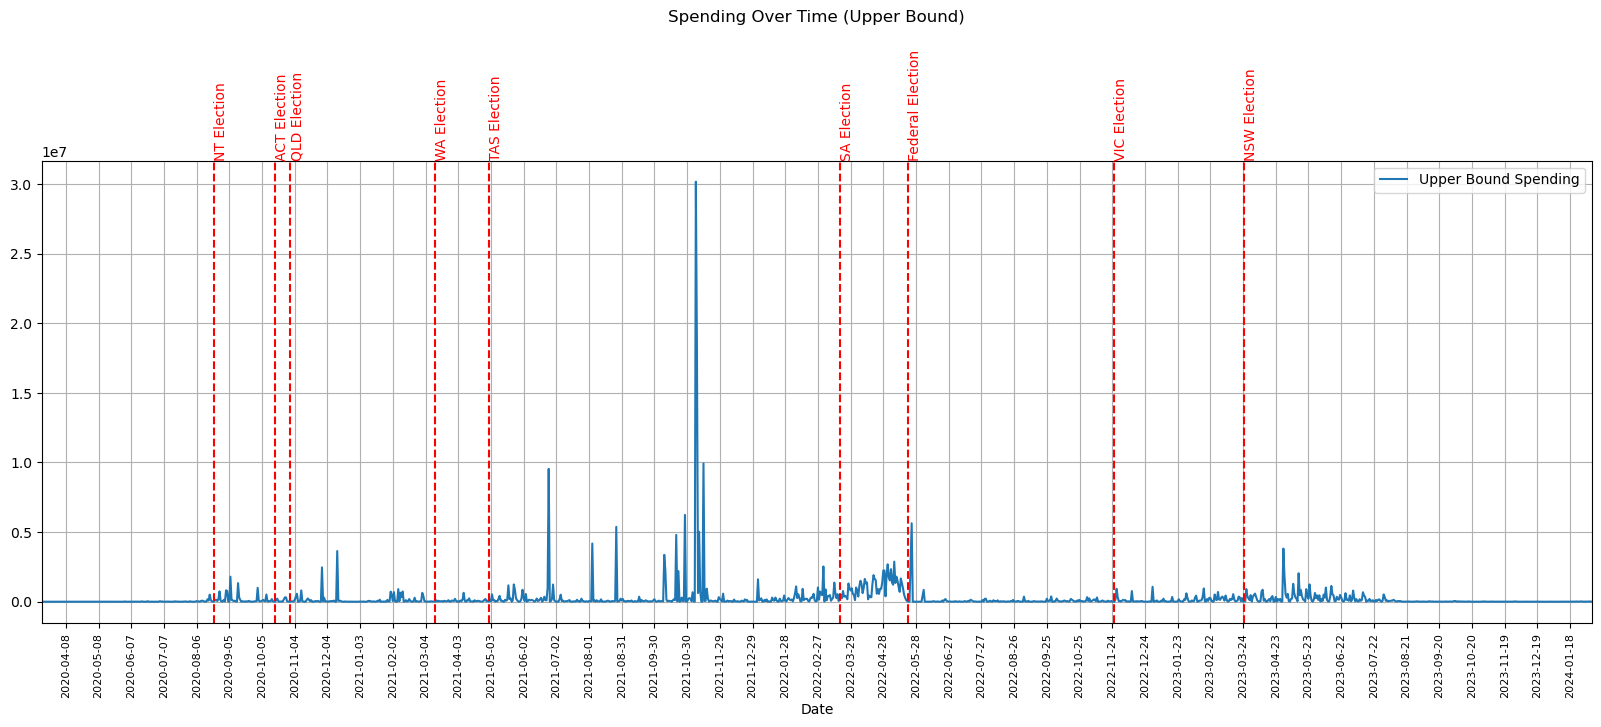

In [20]:
# Plotting the spending over time
plt.figure(figsize=(20, 6))
plt.plot(spending_pd['date'], spending_pd["upper_bound_spend"], label='Upper Bound Spending')
plt.xlabel('Date')
locator = MaxNLocator(integer=True, nbins=48)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().set_xlim(min(spending_pd["date"]), max(spending_pd["date"]))
plt.xticks(rotation=90, ha='center', fontsize=8)

# Show political events
for date, event in events.items():
    plt.axvline(x=date, color='red', linestyle='--')
    plt.text(date, plt.ylim()[1], event, color='red', fontsize=10, rotation=90, verticalalignment='bottom')
    
plt.title('Spending Over Time (Upper Bound)', pad=100)
plt.legend()
plt.grid(True)
plt.show()

In [21]:
party_spending = candidate_ads.groupBy(
    "year", "month", "day", "party"
).agg(
    sum("spend.lower_bound").alias("lower_bound_spend"),
    sum("spend.upper_bound").alias("upper_bound_spend"),
)
party_spending = party_spending.toPandas()
party_spending['date'] = pd.to_datetime(party_spending[['year', 'month', 'day']])
party_spending = party_spending.sort_values(by='date')

/tmp/ipykernel_821242/3055716913.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20c', len(parties))


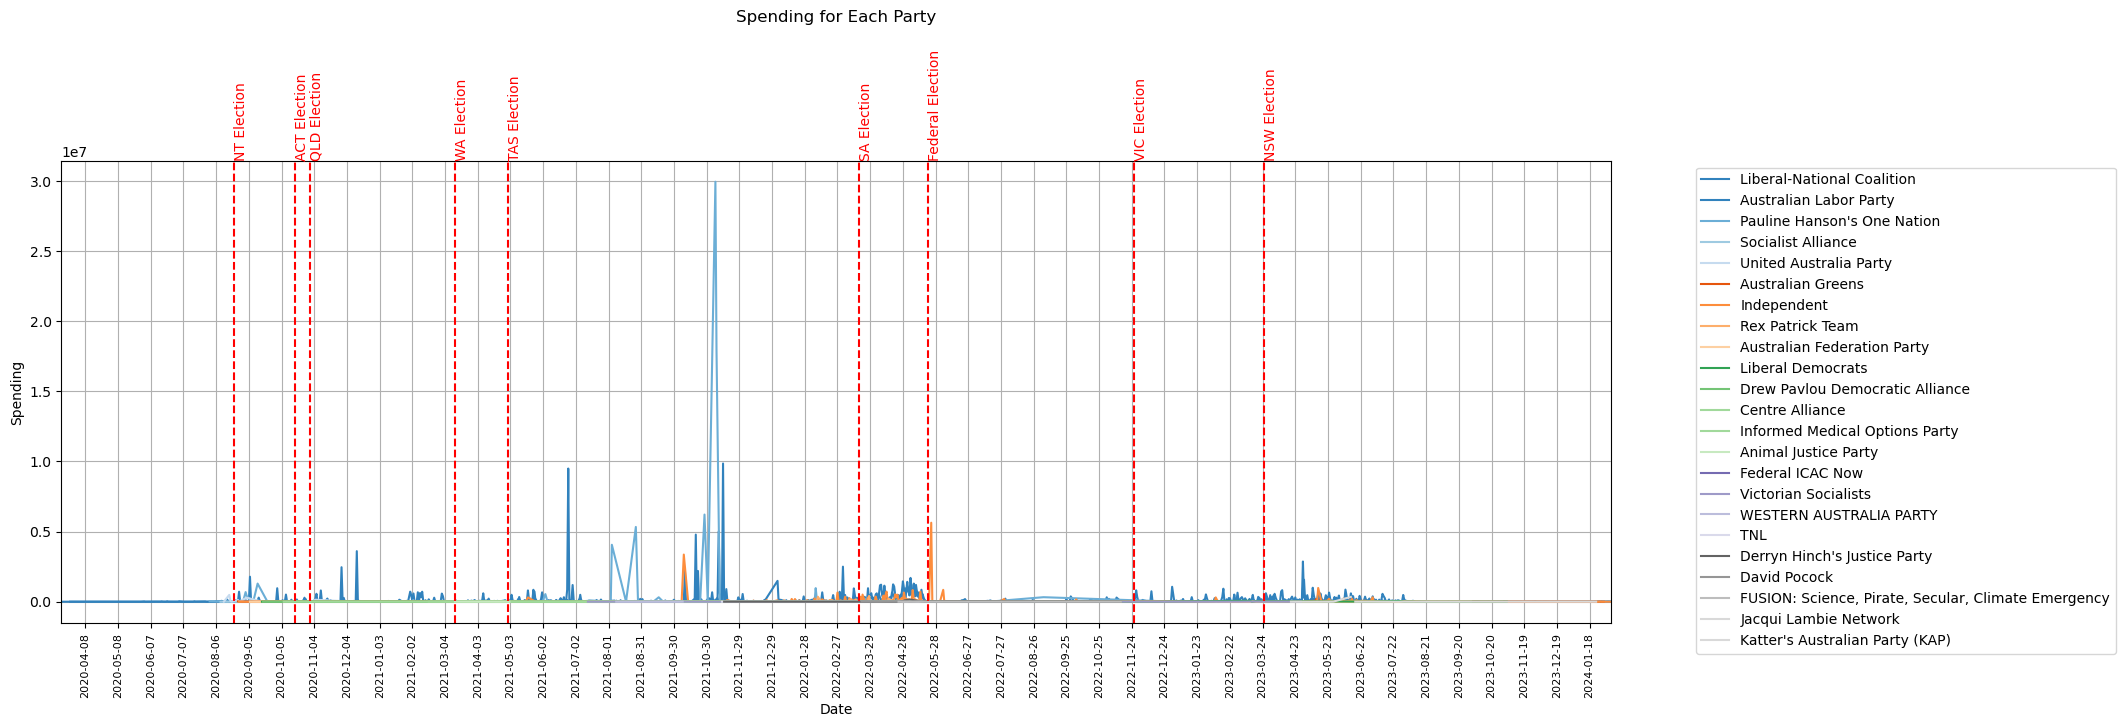

In [22]:
# Plotting the spending over time for each party
parties = party_spending['party'].unique()
colors = plt.cm.get_cmap('tab20c', len(parties))

# Plotting the spending for each party
plt.figure(figsize=(20, 6))
for i, party in enumerate(parties):
    party_data = party_spending[party_spending['party'] == party]
    plt.plot(party_data['date'], party_data['upper_bound_spend'], label=party, color=colors(i))

plt.xlabel('Date')
locator = MaxNLocator(integer=True, nbins=48)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().set_xlim(min(spending_pd["date"]), max(spending_pd["date"]))
plt.xticks(rotation=90, ha='center', fontsize=8)

# Show political events
for date, event in events.items():
    plt.axvline(x=date, color='red', linestyle='--')
    plt.text(date, plt.ylim()[1], event, color='red', fontsize=10, rotation=90, verticalalignment='bottom')
    
plt.ylabel('Spending')
plt.title('Spending for Each Party', pad=100)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

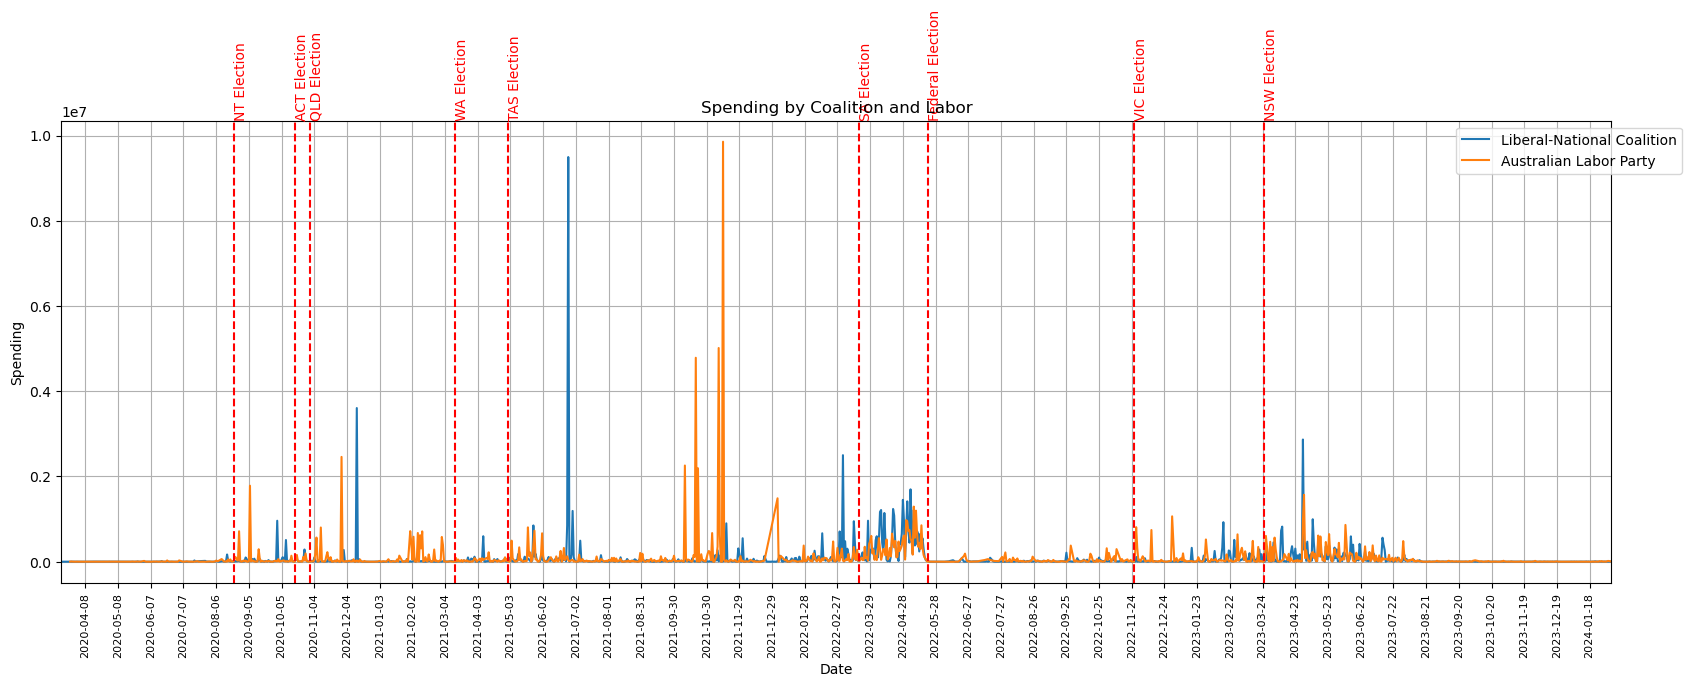

In [23]:
major_parties = ["Liberal-National Coalition", "Australian Labor Party", ]

# Plotting the spending for each party
plt.figure(figsize=(20, 6))
for party in major_parties:
    party_data = party_spending[party_spending['party'] == party]
    plt.plot(party_data['date'], party_data['upper_bound_spend'], label=party)

plt.xlabel('Date')
locator = MaxNLocator(integer=True, nbins=48)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().set_xlim(min(spending_pd["date"]), max(spending_pd["date"]))
plt.xticks(rotation=90, ha='center', fontsize=8)

# Show political events
for date, event in events.items():
    plt.axvline(x=date, color='red', linestyle='--')
    plt.text(date, plt.ylim()[1], event, color='red', fontsize=10, rotation=90, verticalalignment='bottom')

plt.ylabel('Spending')
plt.title('Spending by Coalition and Labor')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

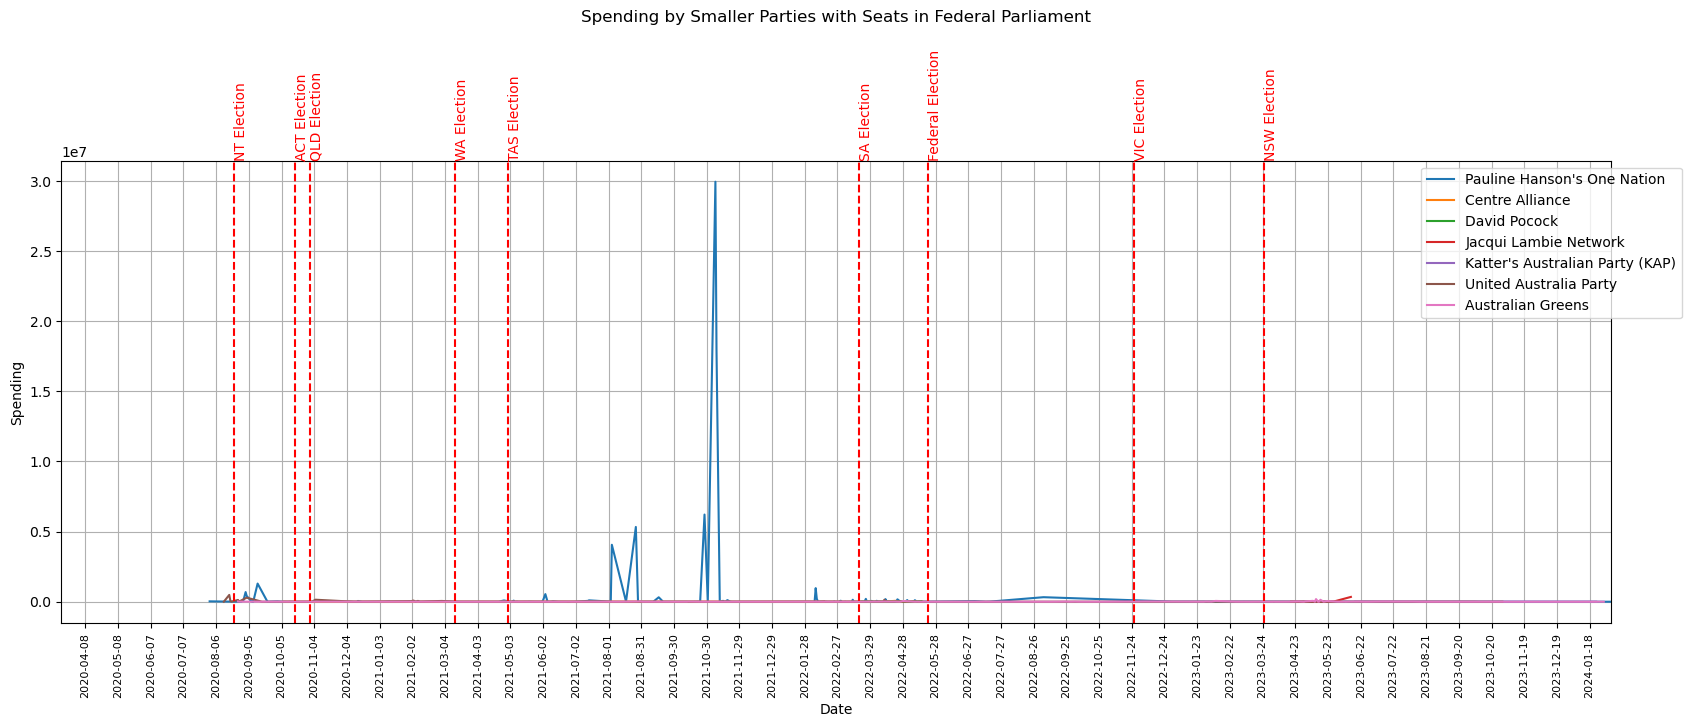

In [24]:
# Spending of smaller parties who hold seats in federal parliament
other_parties = ["Pauline Hanson's One Nation", "Centre Alliance", "David Pocock", "Jacqui Lambie Network", "Katter's Australian Party (KAP)", "United Australia Party", "Australian Greens"]

# Plotting the spending for each party
plt.figure(figsize=(20, 6))
for party in other_parties:
    party_data = party_spending[party_spending['party'] == party]
    plt.plot(party_data['date'], party_data['upper_bound_spend'], label=party)

plt.xlabel('Date')
locator = MaxNLocator(integer=True, nbins=48)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().set_xlim(min(spending_pd["date"]), max(spending_pd["date"]))
plt.xticks(rotation=90, ha='center', fontsize=8)

# Show political events
for date, event in events.items():
    plt.axvline(x=date, color='red', linestyle='--')
    plt.text(date, plt.ylim()[1], event, color='red', fontsize=10, rotation=90, verticalalignment='bottom')
    
plt.ylabel('Spending')
plt.title('Spending by Smaller Parties with Seats in Federal Parliament', pad=100)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

We can see that there was a significant jump in One Nation's spending in 2021-11, which is caused by ad_ids 2944693772446260, 481349949786281, 302085041557273, 428011822321779, 2986693031571148. These ads focus on the COVID-19 vaccinations and are against businesses and governments limiting services/employment to those who are vaccinated. Noting this significant amount of spending, we will remove these records to observe the rest of the spending by the parties.

In [25]:
candidate_ads = candidate_ads.filter(~candidate_ads["ad_id"].isin([2944693772446260, 481349949786281, 302085041557273, 428011822321779, 2986693031571148]))
party_spending = candidate_ads.groupBy(
    "year", "month", "day", "party"
).agg(
    sum("spend.lower_bound").alias("lower_bound_spend"),
    sum("spend.upper_bound").alias("upper_bound_spend"),
)
party_spending = party_spending.toPandas()
party_spending['date'] = pd.to_datetime(party_spending[['year', 'month', 'day']])
party_spending = party_spending.sort_values(by='date')

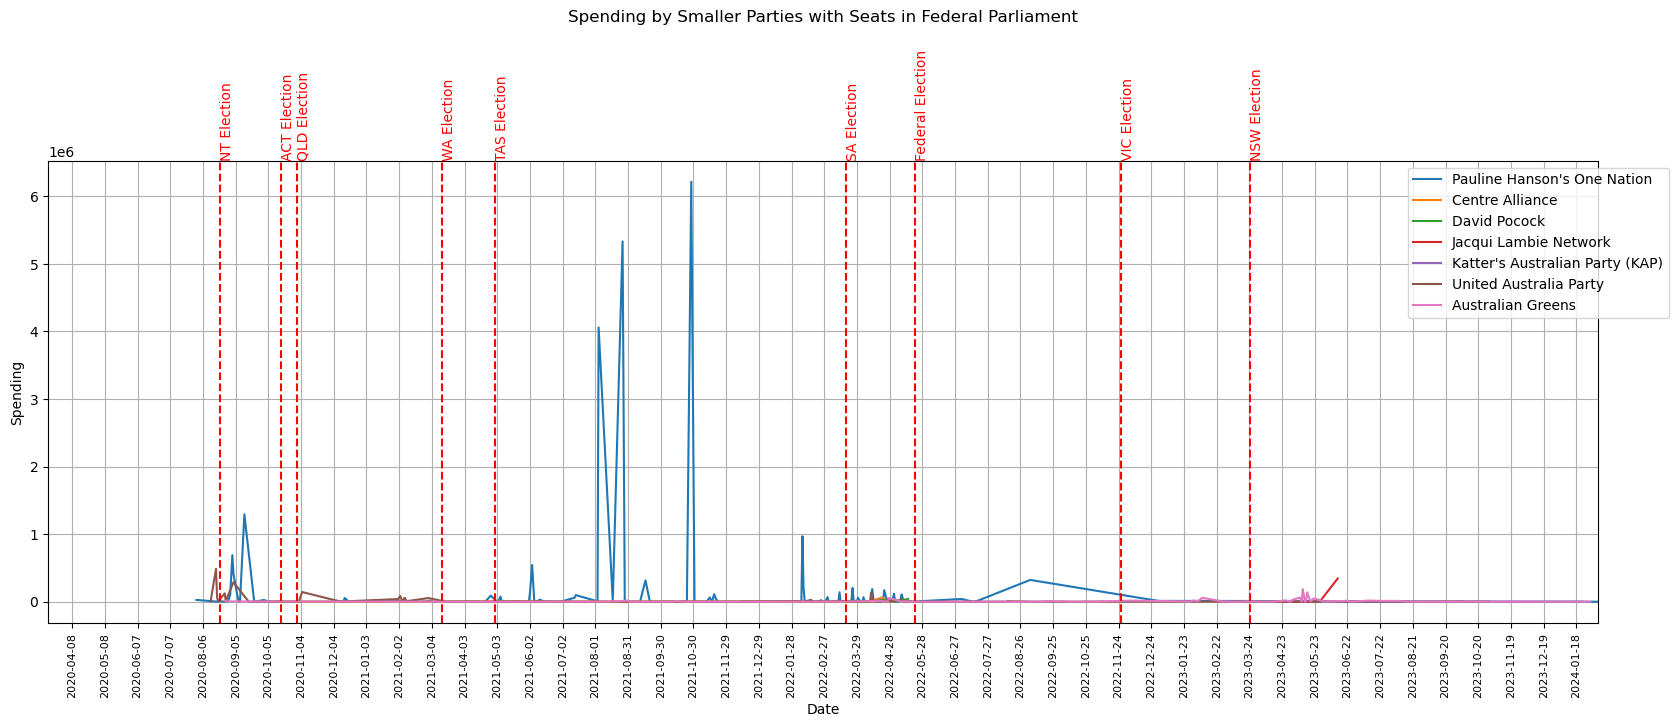

In [26]:
# Spending of smaller parties who hold seats in federal parliament
other_parties = ["Pauline Hanson's One Nation", "Centre Alliance", "David Pocock", "Jacqui Lambie Network", "Katter's Australian Party (KAP)", "United Australia Party", "Australian Greens"]

# Plotting the spending for each party
plt.figure(figsize=(20, 6))
for party in other_parties:
    party_data = party_spending[party_spending['party'] == party]
    plt.plot(party_data['date'], party_data['upper_bound_spend'], label=party)

plt.xlabel('Date')
locator = MaxNLocator(integer=True, nbins=48)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().set_xlim(min(spending_pd["date"]), max(spending_pd["date"]))
plt.xticks(rotation=90, ha='center', fontsize=8)

# Show political events
for date, event in events.items():
    plt.axvline(x=date, color='red', linestyle='--')
    plt.text(date, plt.ylim()[1], event, color='red', fontsize=10, rotation=90, verticalalignment='bottom')

plt.ylabel('Spending')
plt.title('Spending by Smaller Parties with Seats in Federal Parliament', pad=100)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

We can find that even removing the large amount of spending by One Nation on the ad campaign about COVID-19 vaccines, the party's spending is still significantly more than the other smaller parties. Instead, we'll compare it against the two major parties.

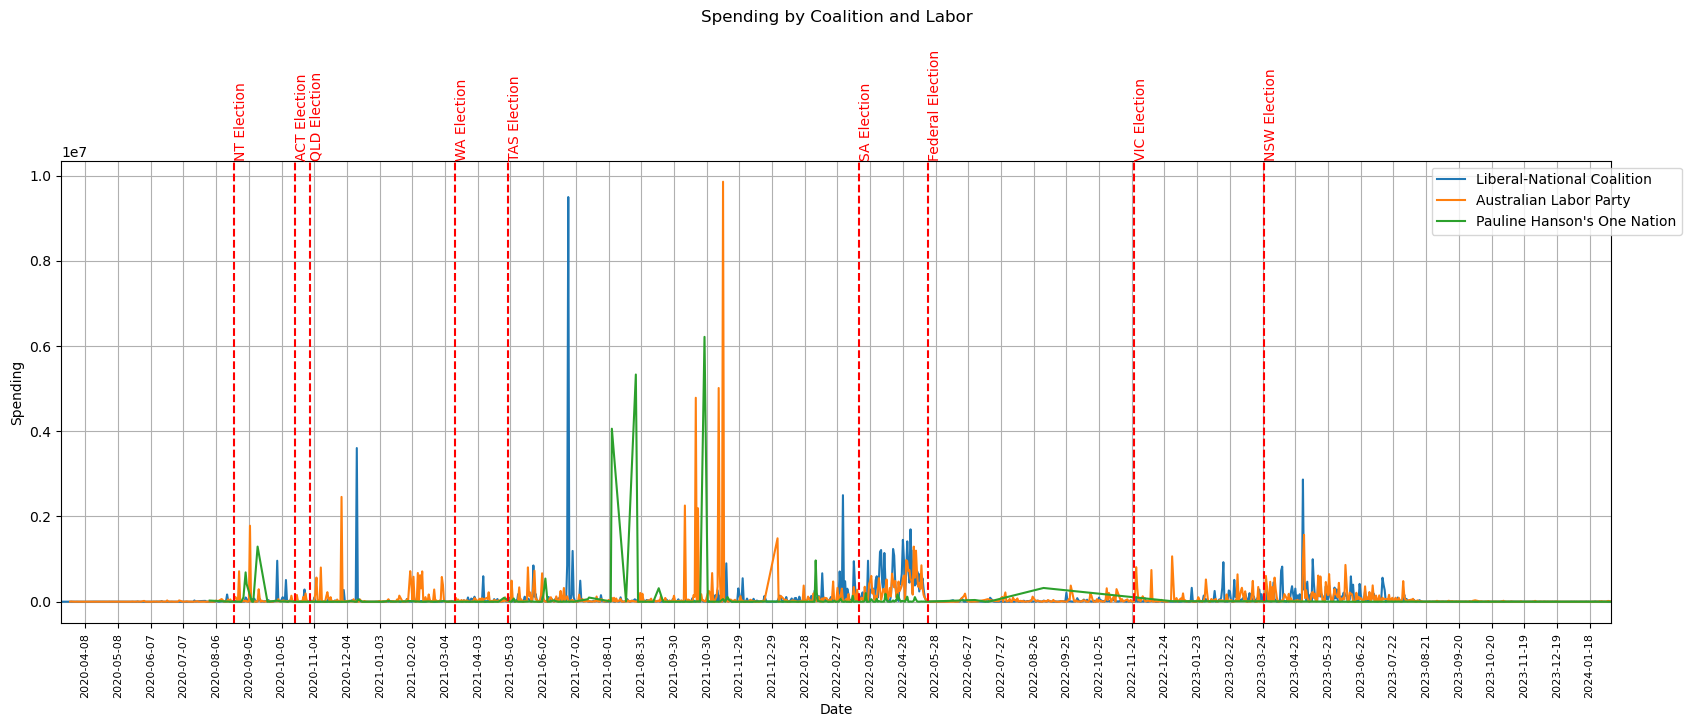

In [27]:
major_parties = ["Liberal-National Coalition", "Australian Labor Party", "Pauline Hanson's One Nation"]

# Plotting the spending for each party
plt.figure(figsize=(20, 6))
for party in major_parties:
    party_data = party_spending[party_spending['party'] == party]
    plt.plot(party_data['date'], party_data['upper_bound_spend'], label=party)

plt.xlabel('Date')
locator = MaxNLocator(integer=True, nbins=48)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().set_xlim(min(spending_pd["date"]), max(spending_pd["date"]))
plt.xticks(rotation=90, ha='center', fontsize=8)

# Show political events
for date, event in events.items():
    plt.axvline(x=date, color='red', linestyle='--')
    plt.text(date, plt.ylim()[1], event, color='red', fontsize=10, rotation=90, verticalalignment='bottom')
    
plt.ylabel('Spending')
plt.title('Spending by Coalition and Labor', pad=100)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

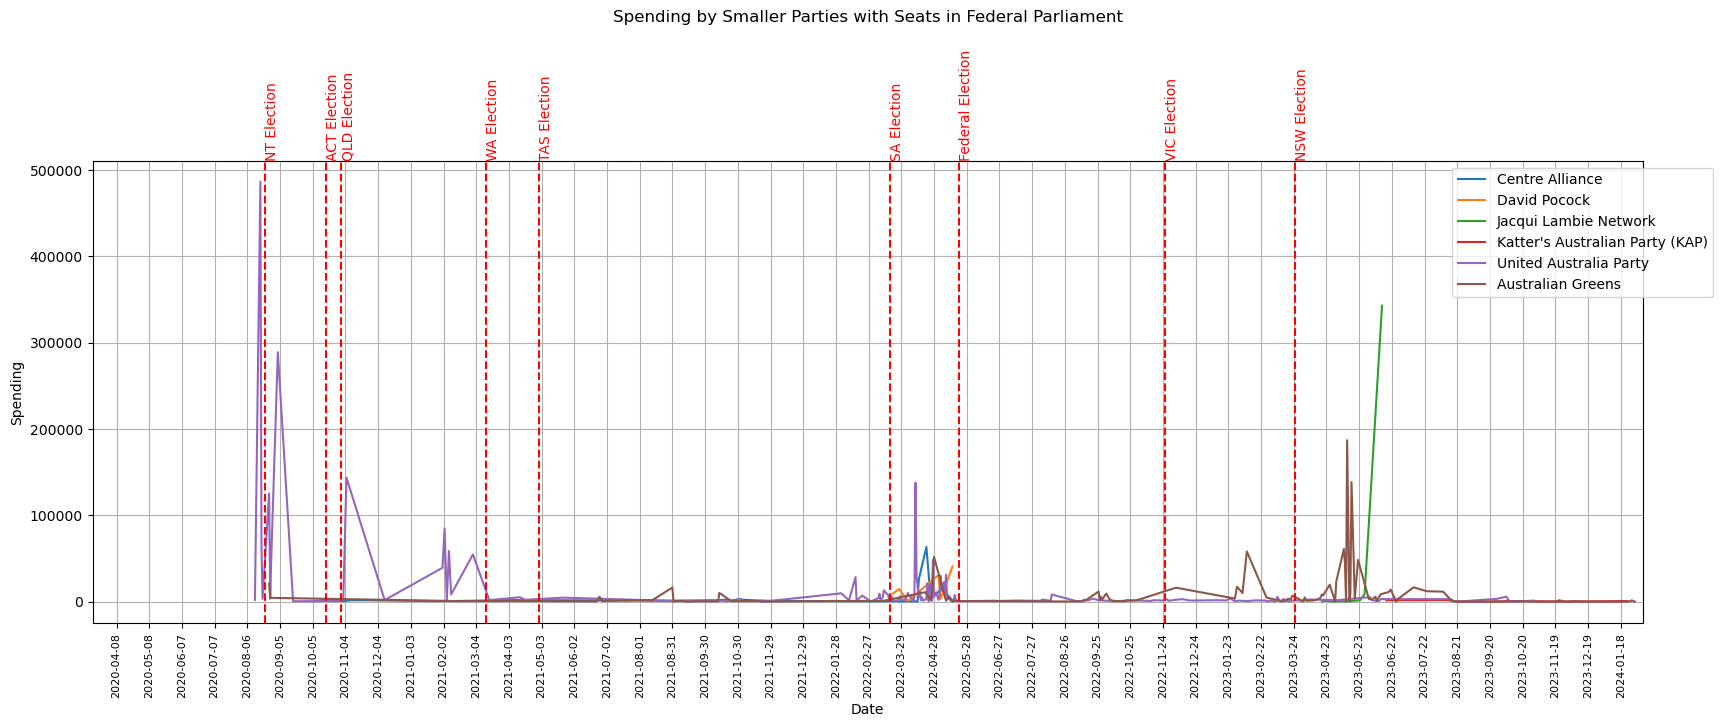

In [28]:
# Spending of smaller parties who hold seats in federal parliament - removing One Nation
other_parties = ["Centre Alliance", "David Pocock", "Jacqui Lambie Network", "Katter's Australian Party (KAP)", "United Australia Party", "Australian Greens"]

# Plotting the spending for each party
plt.figure(figsize=(20, 6))
for party in other_parties:
    party_data = party_spending[party_spending['party'] == party]
    plt.plot(party_data['date'], party_data['upper_bound_spend'], label=party)

plt.xlabel('Date')
locator = MaxNLocator(integer=True, nbins=48)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().set_xlim(min(spending_pd["date"]), max(spending_pd["date"]))
plt.xticks(rotation=90, ha='center', fontsize=8)

# Show political events
for date, event in events.items():
    plt.axvline(x=date, color='red', linestyle='--')
    plt.text(date, plt.ylim()[1], event, color='red', fontsize=10, rotation=90, verticalalignment='bottom')
    
plt.ylabel('Spending')
plt.title('Spending by Smaller Parties with Seats in Federal Parliament', pad=100)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

### Number of Active Ads over Time

In [29]:
active_ads = candidate_ads.groupBy(
    "year", "month", "day"
).count()
active_ads = active_ads.toPandas()
active_ads['date'] = pd.to_datetime(active_ads[['year', 'month', 'day']])
active_ads = active_ads.sort_values(by='date')

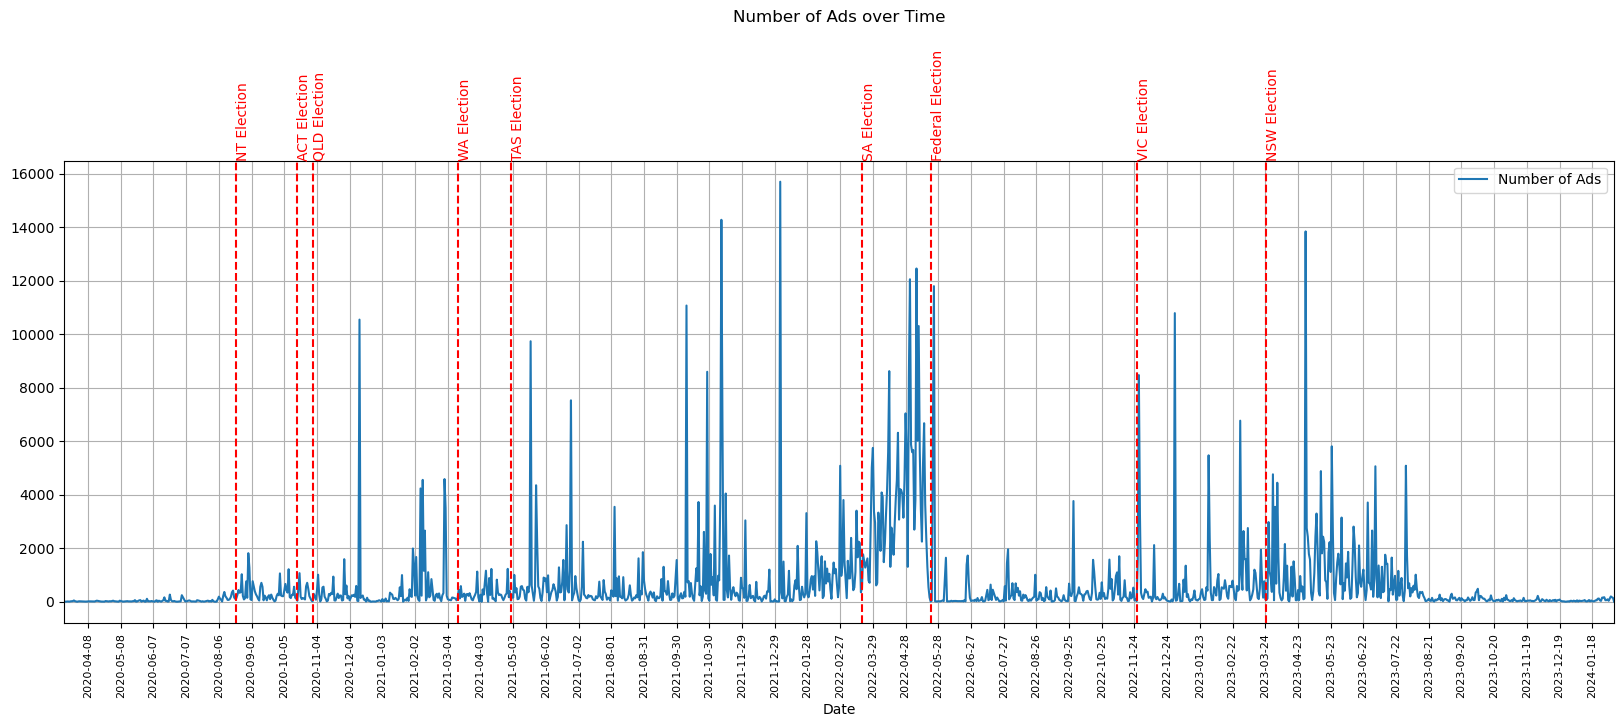

In [30]:
# Number of ads over time (Whole Australia)
plt.figure(figsize=(20, 6))
plt.plot(active_ads['date'], active_ads["count"], label='Number of Ads')
plt.xlabel('Date')
locator = MaxNLocator(integer=True, nbins=48)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().set_xlim(min(active_ads["date"]), max(active_ads["date"]))
plt.xticks(rotation=90, ha='center', fontsize=8)

# Show political events
for date, event in events.items():
    plt.axvline(x=date, color='red', linestyle='--')
    plt.text(date, plt.ylim()[1], event, color='red', fontsize=10, rotation=90, verticalalignment='bottom')
    
plt.title('Number of Ads over Time', pad=100)
plt.legend()
plt.grid(True)
plt.show()

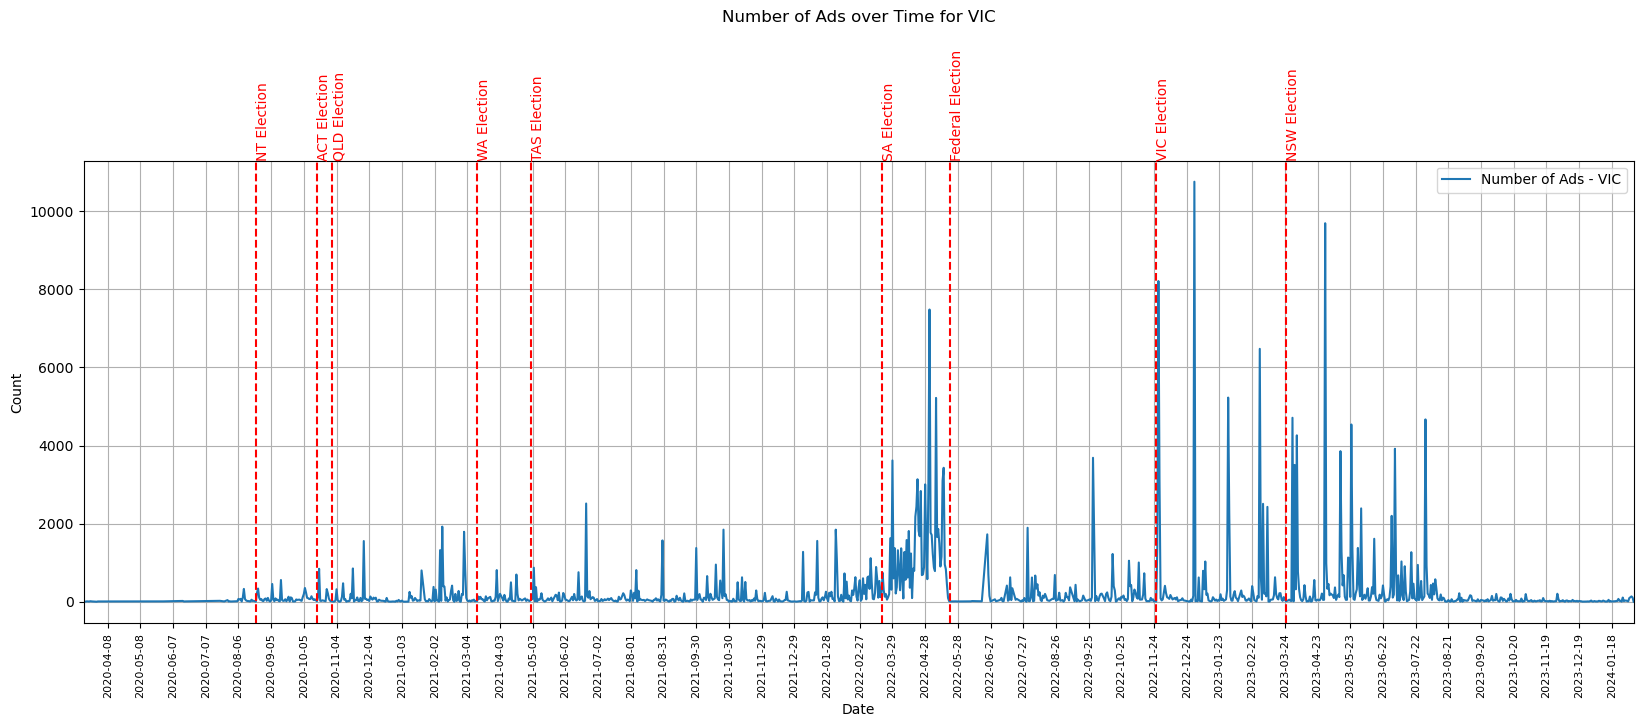

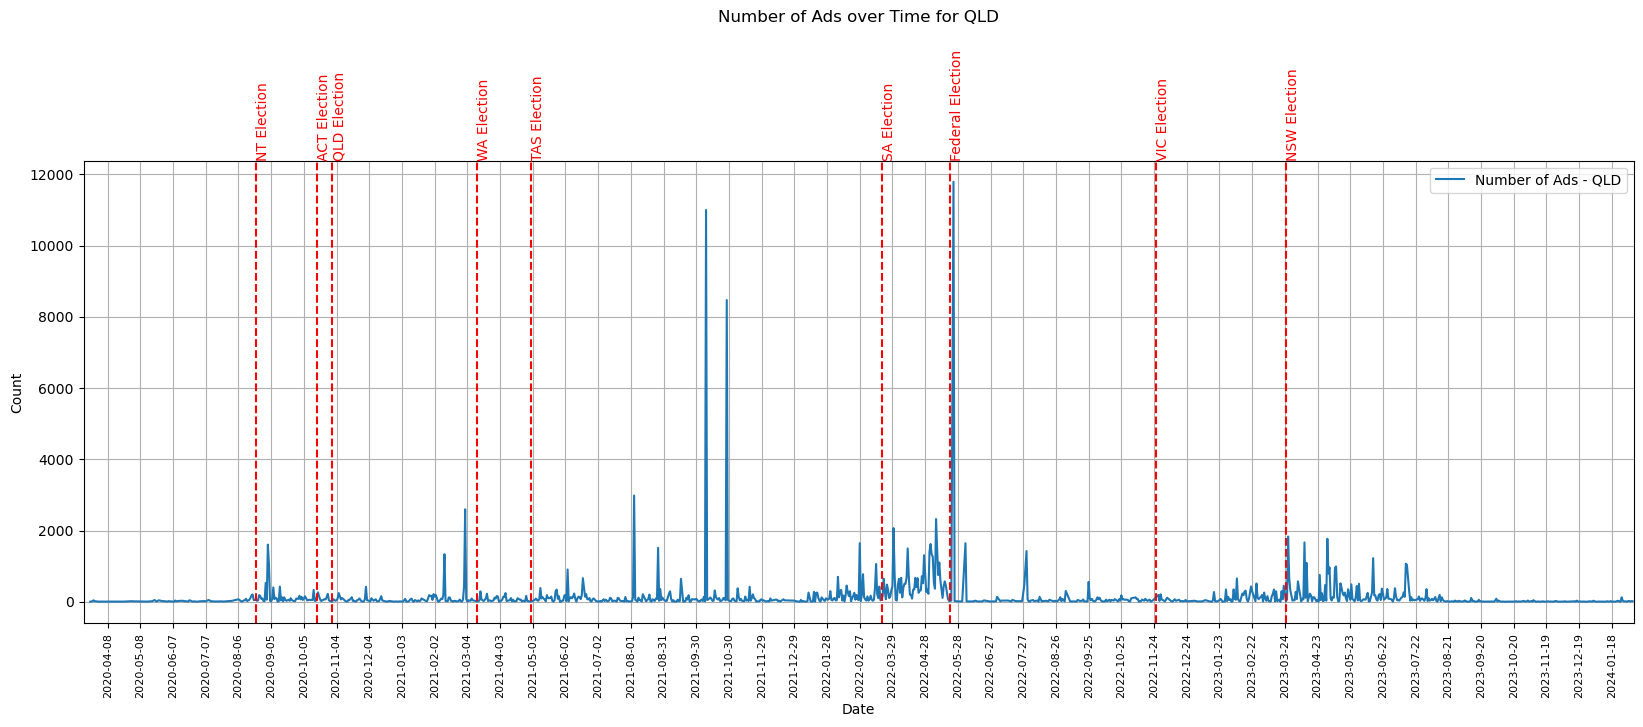

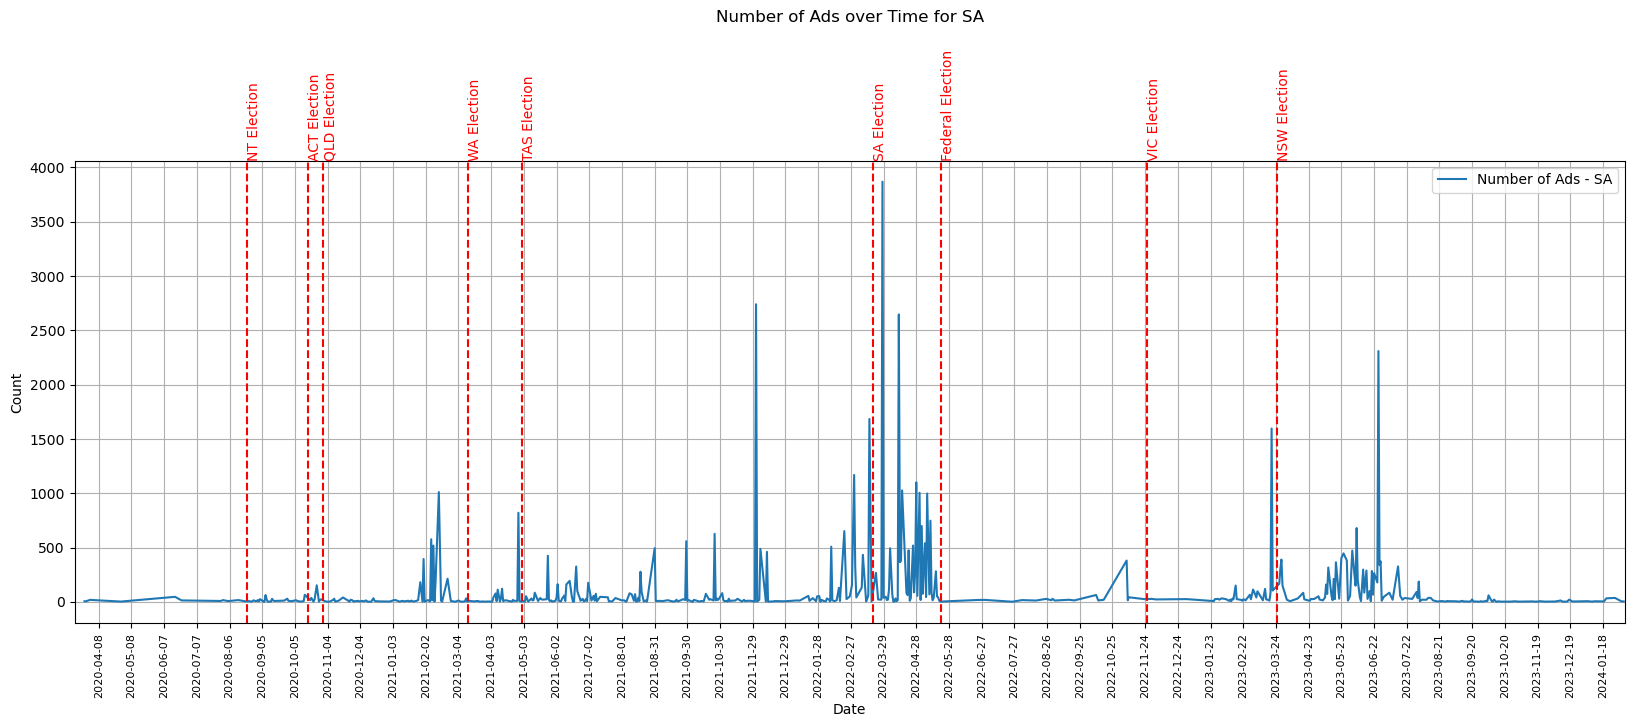

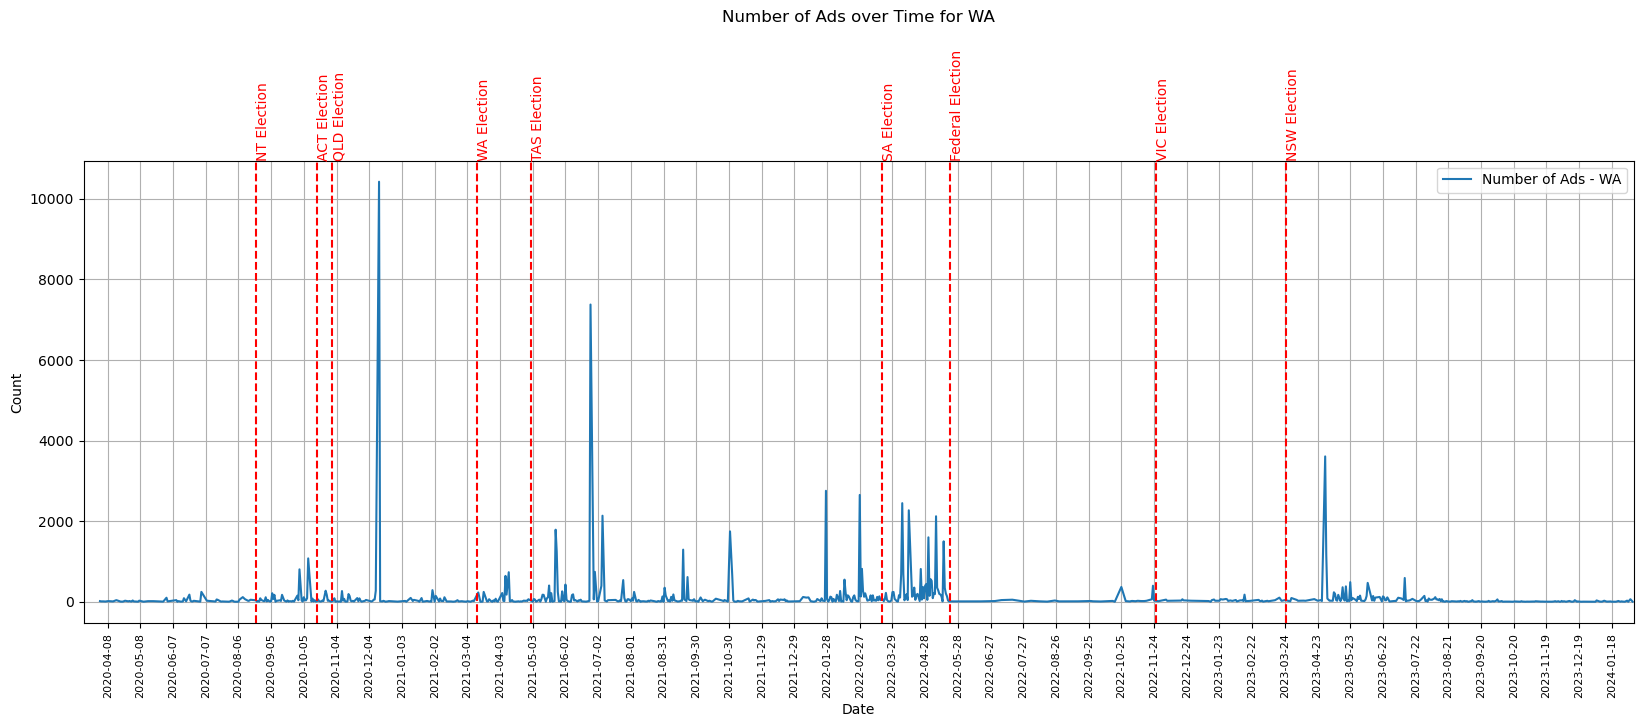

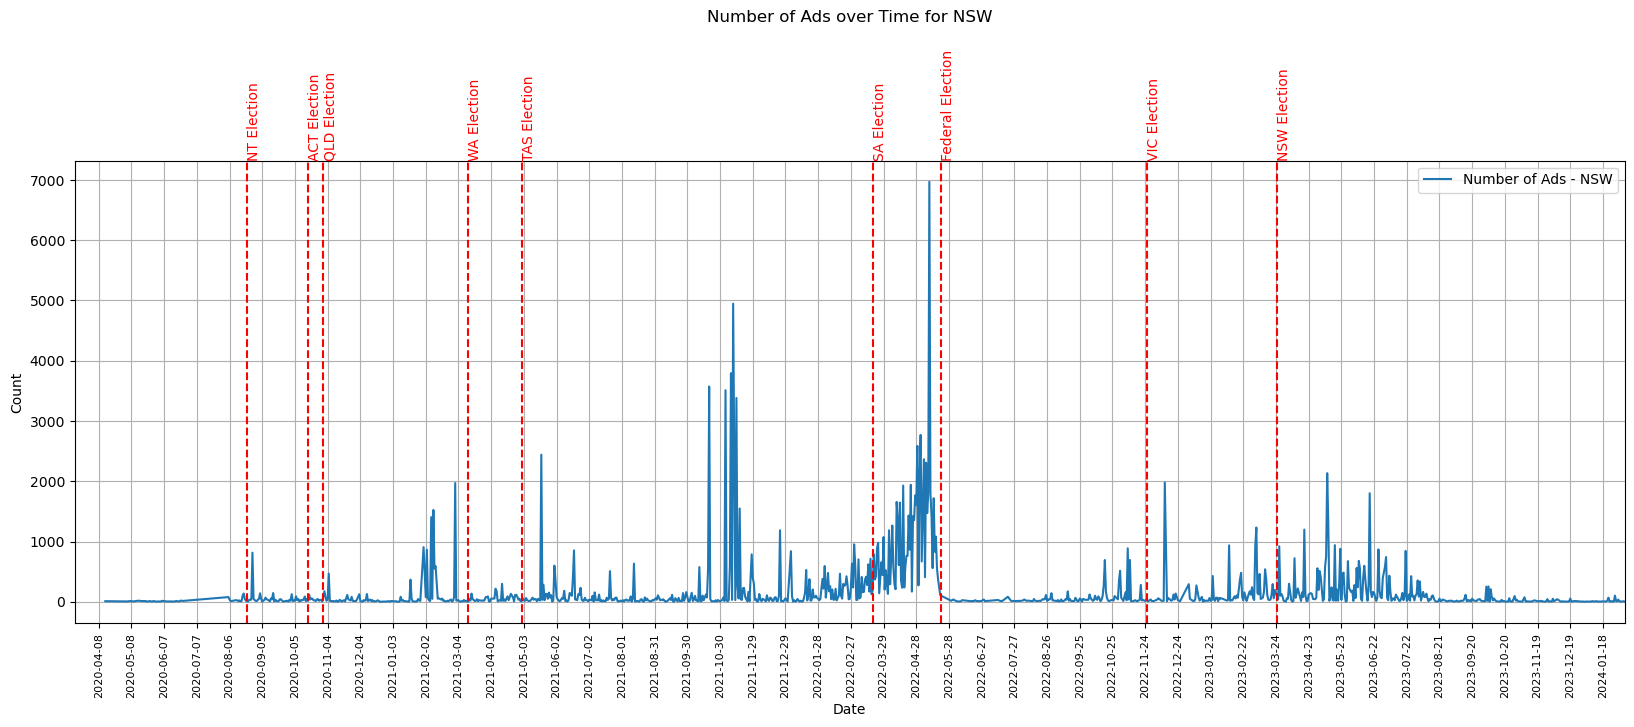

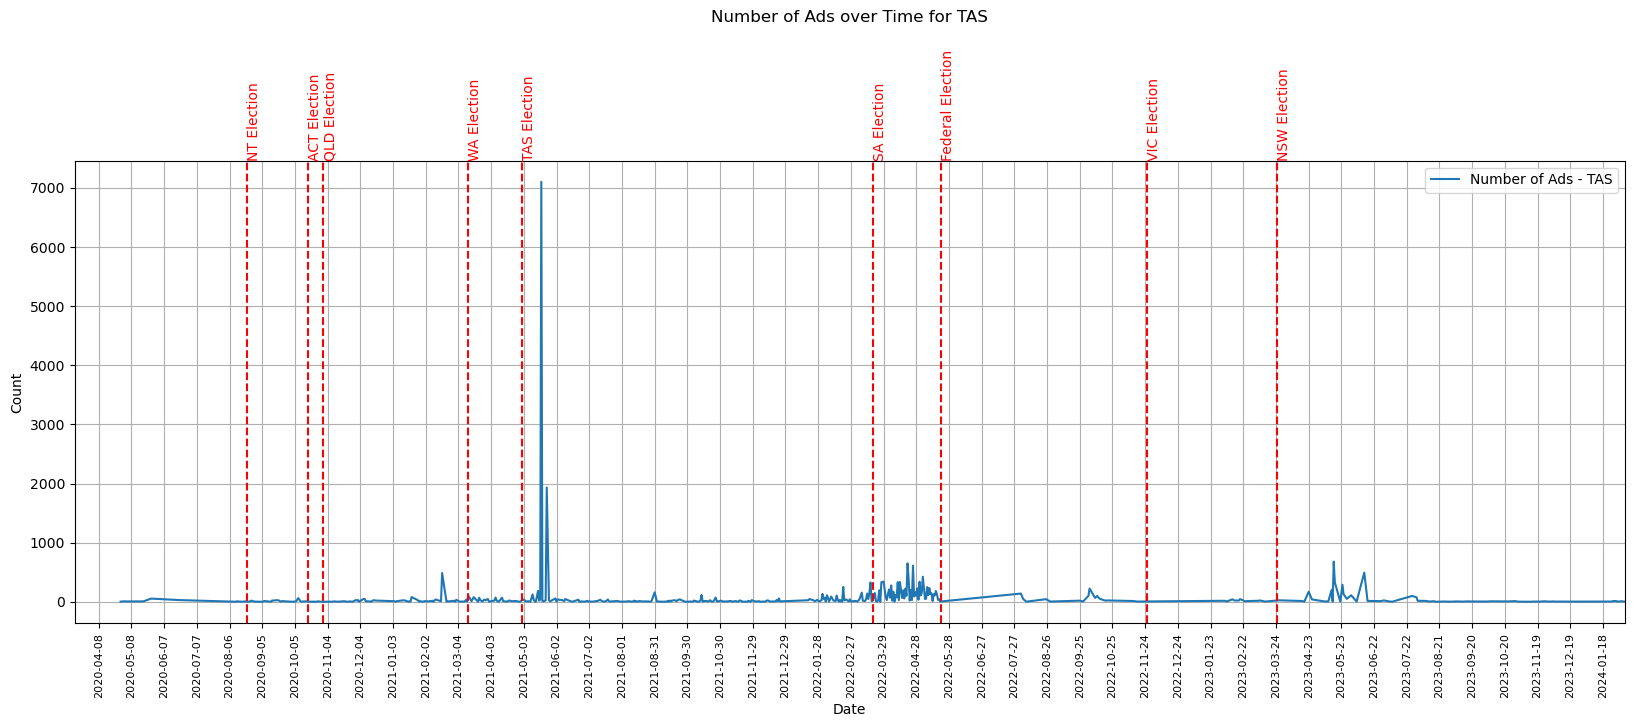

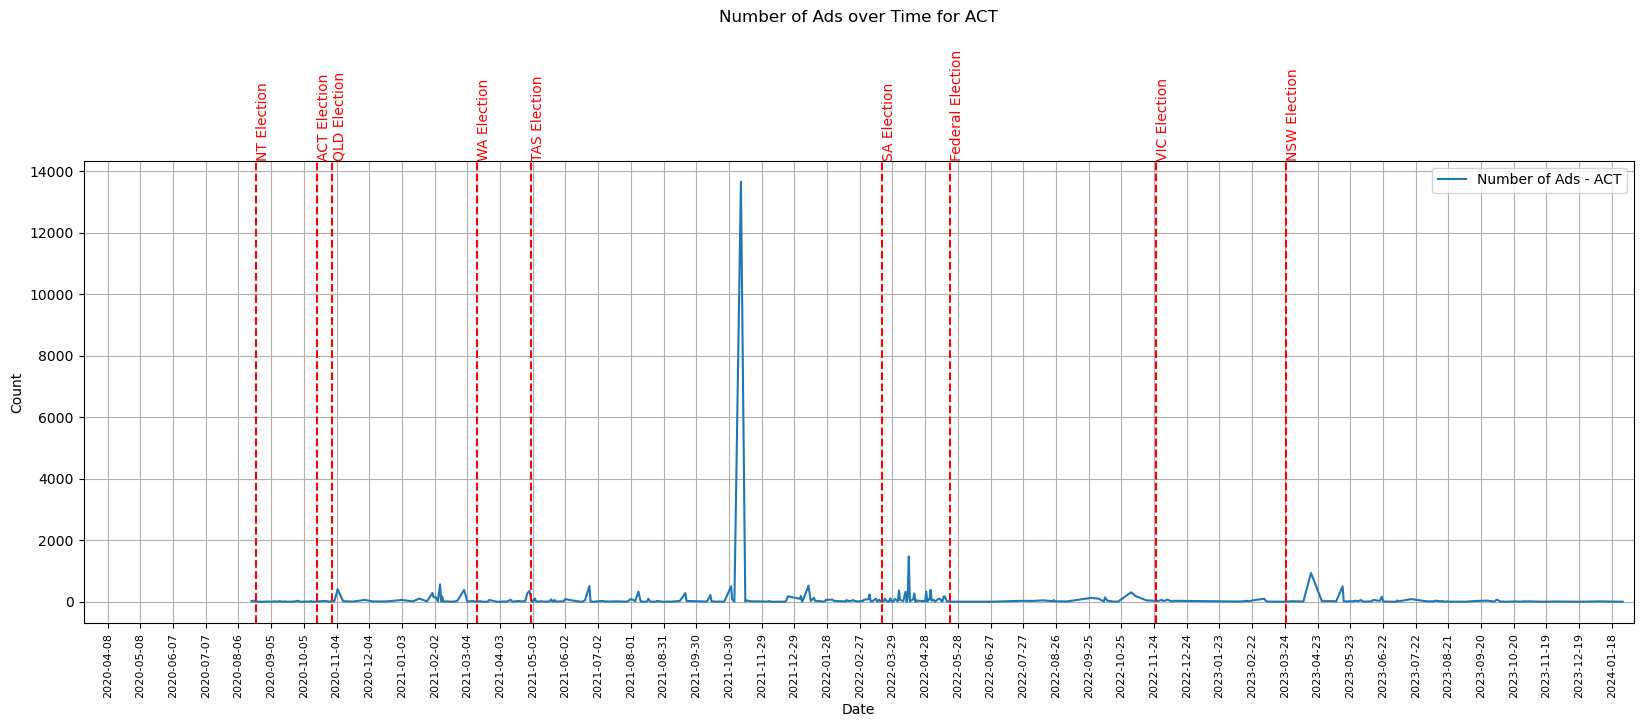

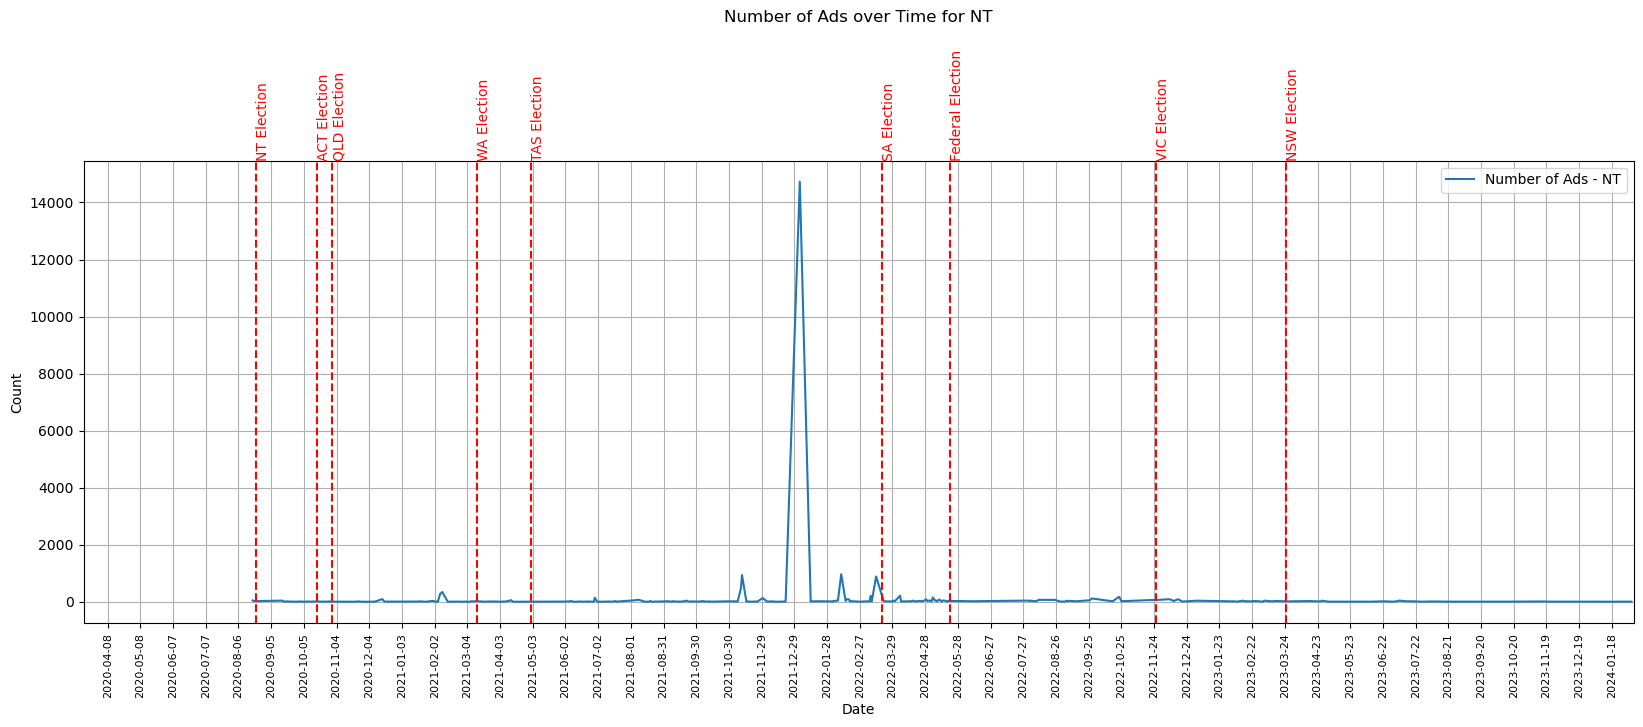

In [31]:
active_ads_state = candidate_ads.groupBy("year", "month", "day", "state").count()
active_ads_state = active_ads_state.toPandas()
active_ads_state['date'] = pd.to_datetime(active_ads_state[['year', 'month', 'day']])
active_ads_state = active_ads_state.sort_values(by='date')
states = active_ads_state['state'].unique()

# Plotting the number of ads over time for each state in separate subplots
for state in states:
    state_data = active_ads_state[active_ads_state['state'] == state]
    
    plt.figure(figsize=(20, 6))
    plt.plot(state_data['date'], state_data["count"], label=f'Number of Ads - {state}')
    plt.xlabel('Date')
    plt.ylabel('Count')
    locator = MaxNLocator(integer=True, nbins=48)
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().set_xlim(min(active_ads_state["date"]), max(active_ads_state["date"]))
    plt.xticks(rotation=90, ha='center', fontsize=8)
    
    # Show political events
    for date, event in events.items():
        plt.axvline(x=date, color='red', linestyle='--')
        plt.text(date, plt.ylim()[1], event, color='red', fontsize=10, rotation=90, verticalalignment='bottom')
    
    plt.title(f'Number of Ads over Time for {state}', pad=100)
    plt.legend()
    plt.grid(True)
    plt.show()


Interestingly, spending by politicians in each state doesn't seem to increase significantly increase before state elections, but across most states, we can find there to be an increase in spending before federal elections. This is likely because of the candidate data being focussed on federal candidates rather than state candidates. We can also see that larger states with more population (QLD, NSW, VIC) tend to have many more ads and exponentially increase the number of ads as the election date approaches, whilst smaller states have relatively unchanged number of ads running, whilst also running significantly fewer ads.

### Demographics Targeted by Ads

In [34]:
# Calculate the average impressions for each ad
candidate_ads = candidate_ads.withColumn("average_impressions", 
                                         (candidate_ads["impressions"]["upper_bound"].cast("double") + 
                                          candidate_ads["impressions"]["lower_bound"].cast("double")) / 2)

# Explode the array of demographic distributions
demographic_df = candidate_ads.selectExpr("explode(demographic_distribution) as demographic", "average_impressions")

# Group by demographic attributes and calculate summary statistics
demographic_summary = demographic_df.groupby(
    "demographic.age", "demographic.gender"
).agg(
    sum(expr("cast(demographic.percentage as double) * average_impressions")).alias("num_impressions")
)

# Display the summary
demographic_summary.show()

+-----+-------+--------------------+
|  age| gender|     num_impressions|
+-----+-------+--------------------+
|18-24|   male|1.1945798396822526E9|
|13-17|unknown|  1484915.1952770015|
|55-64| female| 1.385961818421031E9|
|  65+|unknown| 5.856239168700099E7|
|55-64|   male|1.5722498626899865E9|
|18-24| female|1.2478367424367461E9|
|13-17|   male|1.6255390588798009E7|
|45-54|   male|1.6067419481718607E9|
|55-64|unknown| 3.945697741548966E7|
|25-34| female|1.5001423958171194E9|
|45-54|unknown|  4.76152519574396E7|
|13-17| female| 2.772741667781845E7|
|35-44|unknown| 4.426765470877249E7|
|45-54| female|1.3244405970813732E9|
|25-34|   male|1.8091376288009396E9|
|35-44|   male|1.6216300380125623E9|
|  65+| female|1.7517803289216073E9|
|25-34|unknown|2.4359079672807954E7|
|18-24|unknown|2.2786415306434494E7|
|35-44| female| 1.361020087419703E9|
+-----+-------+--------------------+
only showing top 20 rows



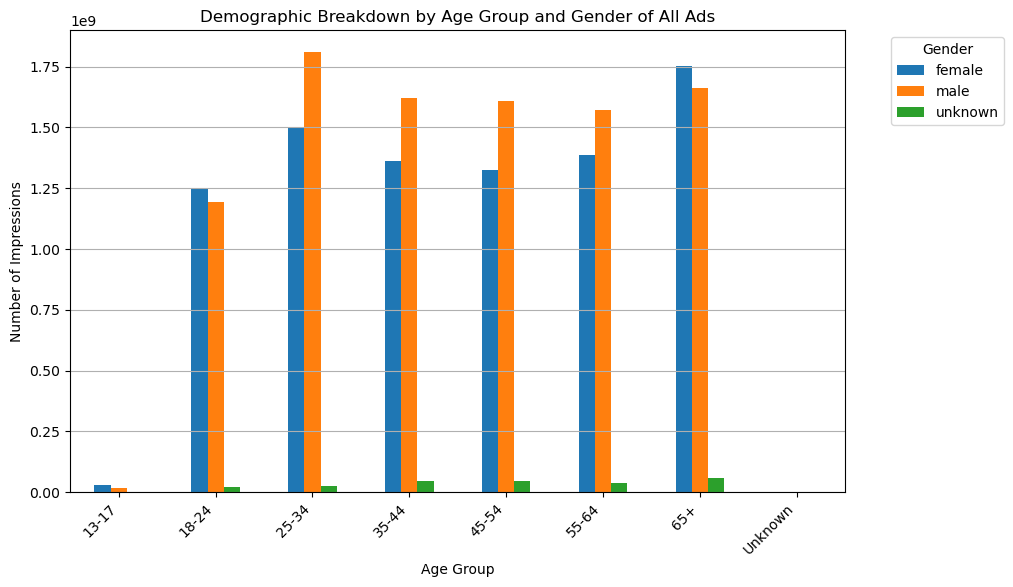

In [35]:
demographic_summary_pd = demographic_summary.toPandas()

# Pivot the data to have age groups as rows and genders as columns
pivot_df = demographic_summary_pd.pivot(index='age', columns='gender', values='num_impressions')

# Plotting the bar chart
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Age Group')
plt.ylabel('Number of Impressions')
plt.title('Demographic Breakdown by Age Group and Gender of All Ads')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')

plt.show()

In [38]:
average_percentage = demographic_df.groupby(
    "demographic.age", "demographic.gender"
).agg(
    avg("demographic.percentage").alias("average_percentage")
)

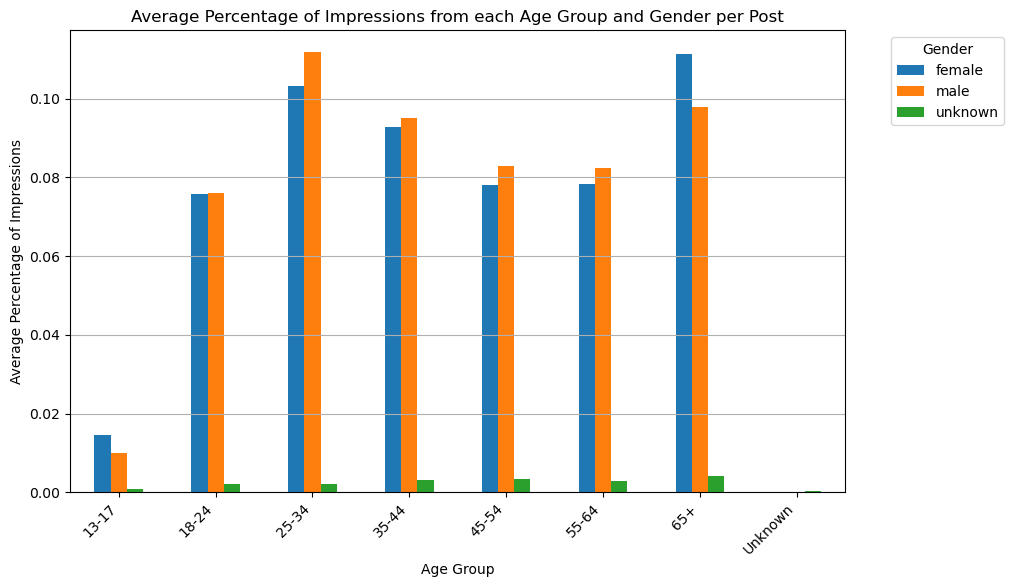

In [39]:
# Average percentage breakdown of demographics per post
average_percentage = average_percentage.toPandas()
pivot_df = average_percentage.pivot(index='age', columns='gender', values='average_percentage')
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Age Group')
plt.ylabel('Average Percentage of Impressions')
plt.title('Average Percentage of Impressions from each Age Group and Gender per Post')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')

plt.show()

In [40]:
state_demographic_df = candidate_ads.selectExpr("explode(demographic_distribution) as demographic", "state")

state_percentages = state_demographic_df.groupby(
    "demographic.age", "demographic.gender", "state"
).agg(
    avg("demographic.percentage").alias("average_percentage")
)

# Display the summary
state_percentages.show()

+-----+-------+-----+--------------------+
|  age| gender|state|  average_percentage|
+-----+-------+-----+--------------------+
|25-34|   male|   WA|  0.0941734565389506|
|55-64| female|  TAS| 0.08430613150469655|
|25-34|unknown|  QLD|0.001343473902974...|
|45-54|   male|  QLD| 0.09011550473366048|
|25-34|   male|  QLD| 0.08851169998987345|
|18-24|   male|  QLD| 0.06342794495289535|
|  65+| female|   WA| 0.12432597704720665|
|18-24| female|  ACT| 0.05450831249164095|
|25-34| female|  ACT| 0.13262641810487305|
|13-17|unknown|   SA| 9.56652884615385E-4|
|35-44| female|   NT| 0.09250333215216956|
|18-24|   male|   NT|  0.1178553009648089|
|55-64|unknown|  TAS|0.002437831847630...|
|55-64| female|   NT|0.042975308490230915|
|45-54|unknown|  TAS|0.002170614727908...|
|25-34|unknown|   NT|0.002566272010232...|
|18-24| female|  NSW| 0.08937852749823647|
|45-54|unknown|   NT|0.003132892663825...|
|18-24| female|  QLD|  0.0694038442472359|
|25-34| female|  VIC| 0.10882956930823132|
+-----+----

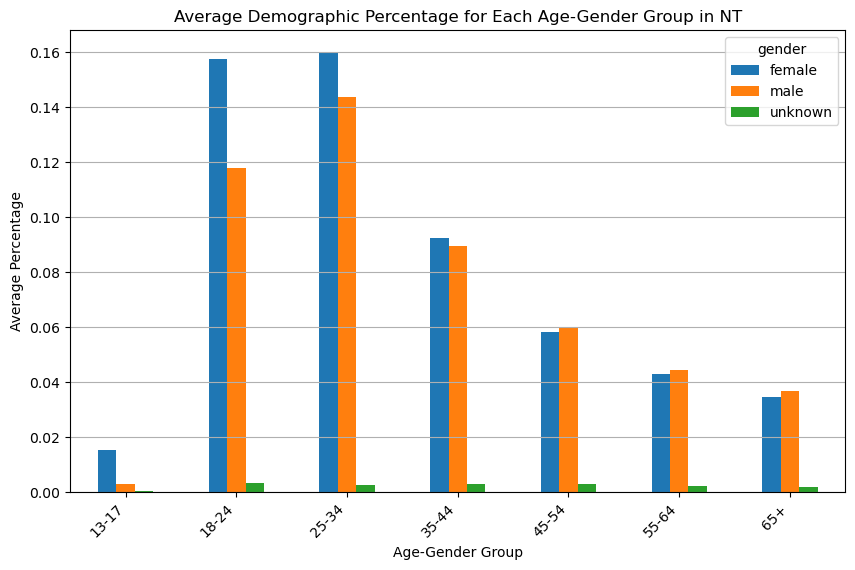

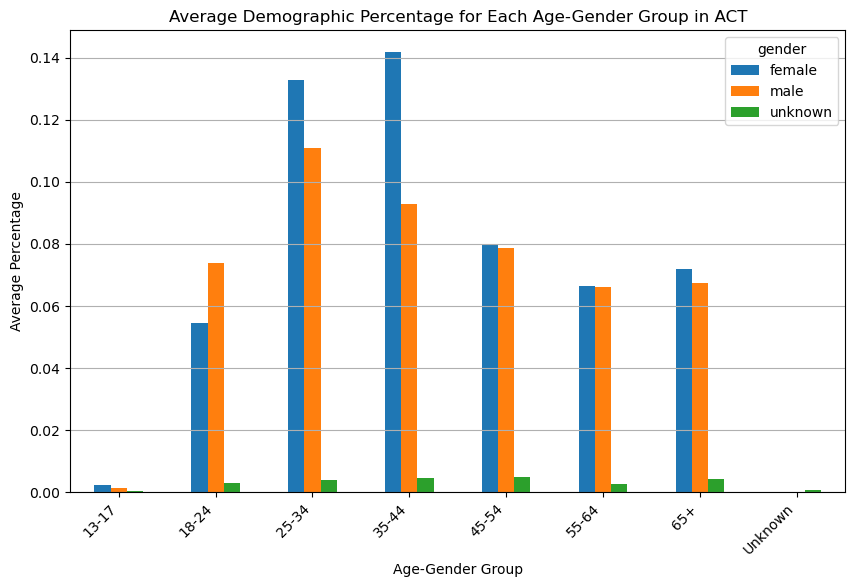

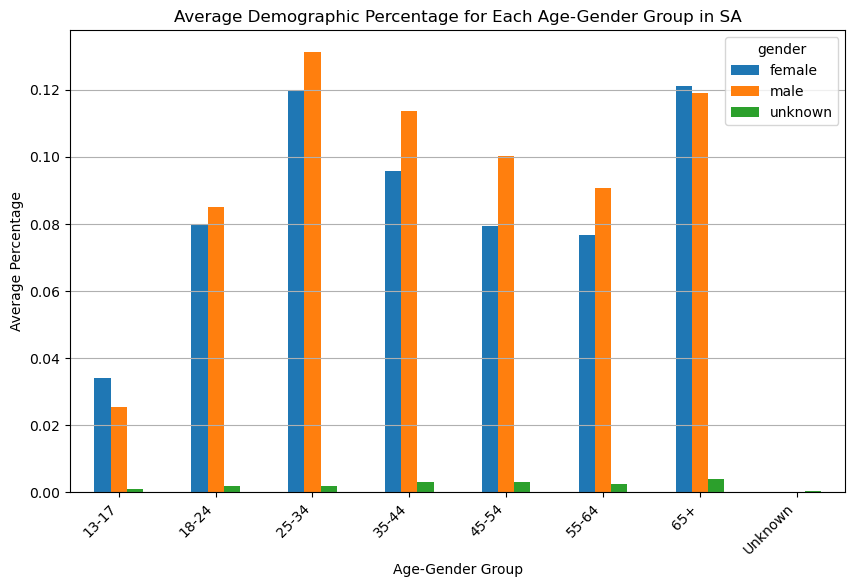

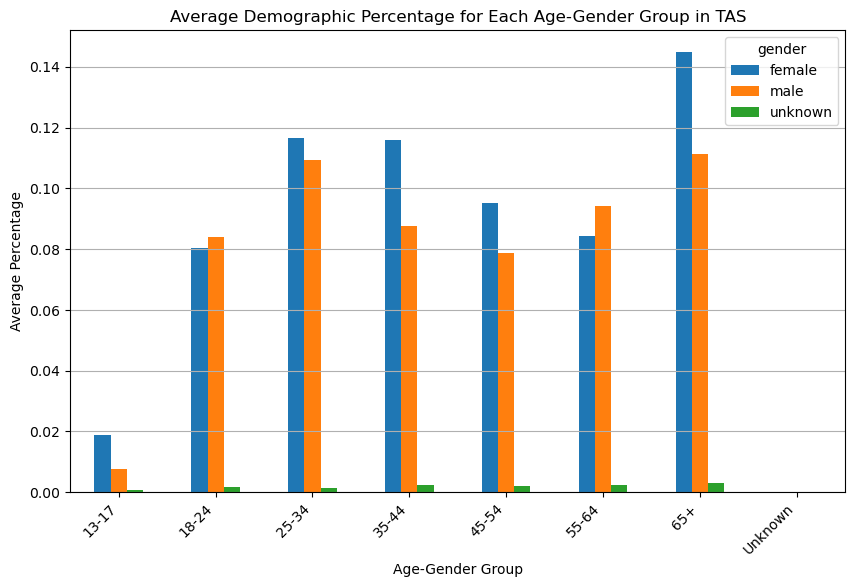

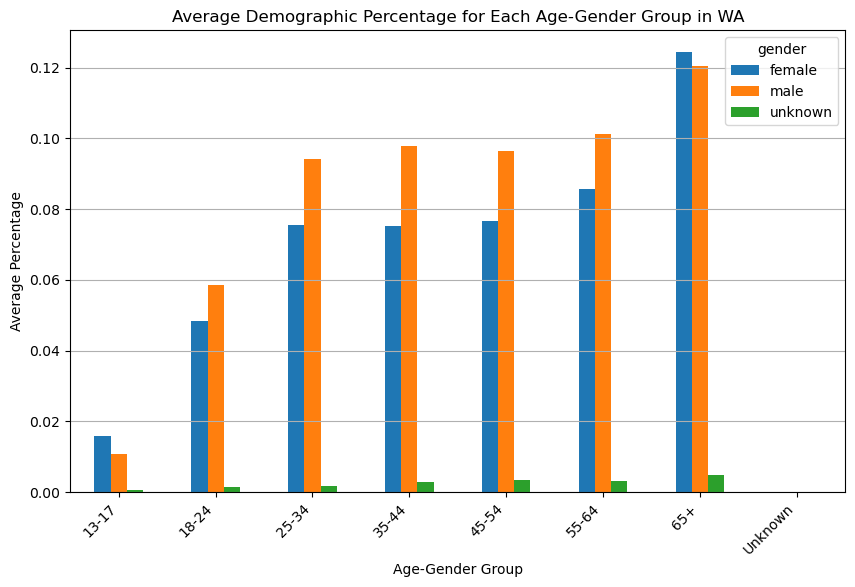

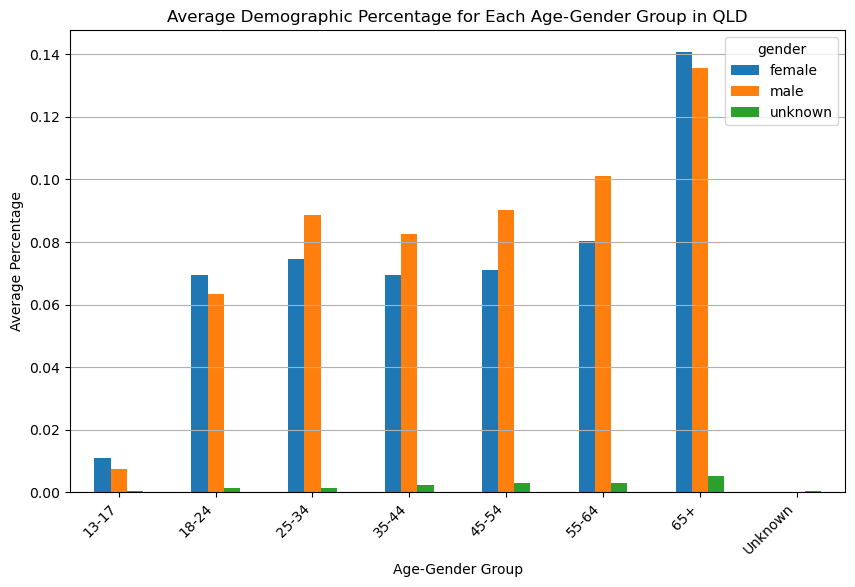

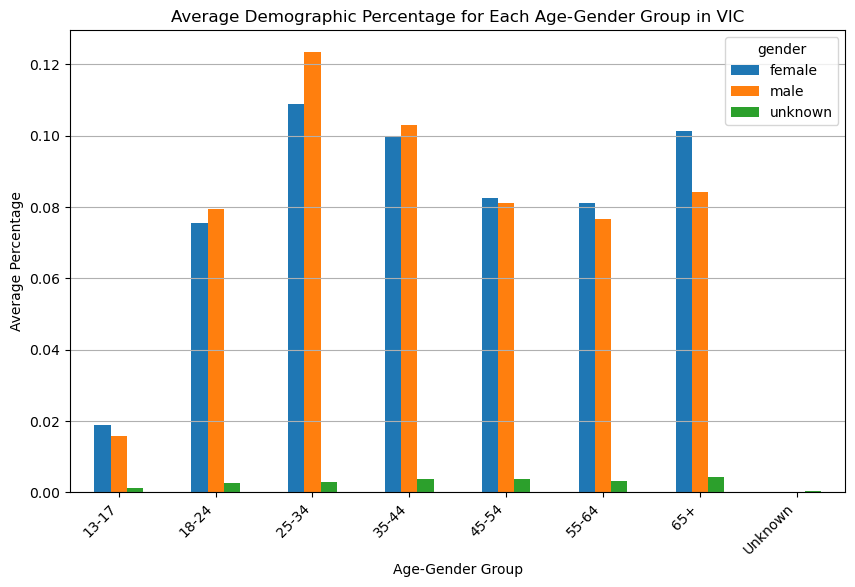

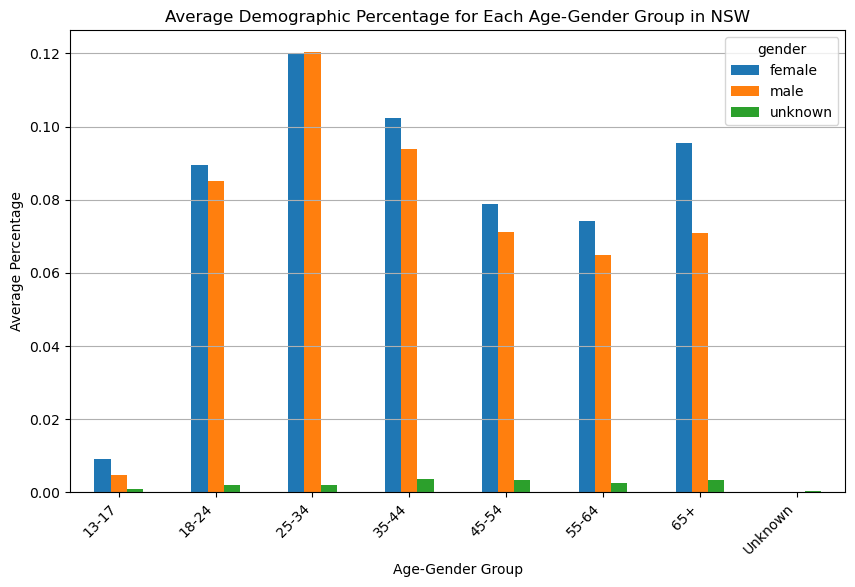

In [41]:
# Get unique states
states = state_percentages.select("state").distinct().rdd.map(lambda row: row[0]).collect()

# Plotting the demographic percentages for each state
for state in states:
    state_data = state_percentages.filter(state_percentages["state"] == state).toPandas()
    pivot_df = state_data.pivot(index='age', columns='gender', values='average_percentage')
    
    # Create a bar chart for the current state
    plt.figure(figsize=(10, 6))
    pivot_df.plot(kind='bar', ax=plt.gca())
    plt.xlabel('Age-Gender Group')
    plt.ylabel('Average Percentage')
    plt.title(f'Average Demographic Percentage for Each Age-Gender Group in {state}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    
    plt.show()


### Average Spending Statistics